https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [563]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from pandas import read_csv
from matplotlib import pyplot
from datetime import datetime

from math import sqrt
from numpy import concatenate, zeros
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN, Activation

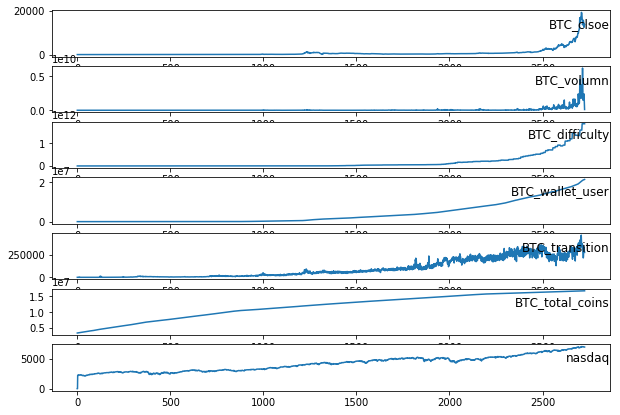

In [391]:
def plotData(fileName):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    columns = dataset.columns
    num_columns = len(columns)
    
    pyplot.figure(figsize=(10, num_columns)) # TODO - update figure size automatically
    for i in range(num_columns):
        pyplot.subplot(num_columns, 1, i+1)
        pyplot.plot(values[:, i])
        pyplot.title(columns[i], y=0.5, loc='right')
    pyplot.show()
        
plotData('result.csv')

In [408]:
# convert series to supervised learning
def seriesToSupervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prepareData(fileName, scaler, lookBack=1, trainPercent=0.7, encodeColumnIndex=[]):
    dataset = read_csv(fileName, header=0, index_col=0)
    values = dataset.values
    n_features = len(dataset.columns)
    print(dataset.columns)
    # integer encode direction
    for i in encodeColumnIndex:
        values[:,i] = LabelEncoder().fit_transform(values[:,i])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = seriesToSupervised(scaled, lookBack, 1)
    
    # split into train and test sets
    values = reframed.values
    trainSize = int(trainPercent * len(values))
    train = values[:trainSize, :]
    test = values[trainSize:, :]
    # split into input and outputs
    
    n_obs = lookBack * n_features
    trainX, trainY = train[:, :n_obs], train[:, -n_features]
    testX, testY = test[:, :n_obs], test[:, -n_features]
    # reshape input to be 3D [samples, timesteps, features]
    trainX = trainX.reshape((trainX.shape[0], lookBack, n_features))
    testX = testX.reshape((testX.shape[0], lookBack, n_features))
    
    return trainX, trainY, testX, testY

#trainX, trainY, testX, testY = prepareData('pollution.csv', scaler, lookBack=7, encodeColumnIndex=[4])
#print(trainX.shape, trainY.shape, testX.shape, testY.shape)

In [569]:
def trainLSTM(trainX, trainY, testX, testY, neurons=100, epochs=80, batchSize=128, dropout=0.1, verbose=1, loss='mae', optimizer='adam', plot=True):
    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=dropout))
    #model.add(LSTM(neurons, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=dropout, return_sequences=True))
    #model.add(LSTM(neurons, return_sequences=True))
    #model.add(LSTM(neurons))
    model.add(Dense(1))
    #model.add(Activation('linear'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, validation_data=(testX, testY), verbose=verbose, shuffle=False)
    
    # plot history
    if (plot):
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()
    
    return model, history
    

#model, history = trainLSTM(trainX, trainY, testX, testY, 50)

In [579]:
def reverseScale(y, scaler):
    n_scaled=len(scaler.data_max_)
    inv = concatenate((y, zeros([y.shape[0], n_scaled-1])), axis=1) # don't case the 
    inv = scaler.inverse_transform(inv)
    return inv[:, 0]

def makePrediction(model, trainX, trainY, testX, testY, scaler, rmse=True, plot=True, printNumResults=20):
    # make a prediction
    yhat = model.predict(testX)
    shapedY = testY.reshape(len(testY), 1)
    
    if (rmse):
        rmse = sqrt(mean_squared_error(yhat, shapedY))
        print('Test RMSE: %.3f' % rmse)

    predictedY = reverseScale(yhat, scaler)
    y = reverseScale(shapedY, scaler)
    
    if (plot):
        pyplot.plot(y[-300:], label = 'y')
        pyplot.plot(predictedY[-300:], label = 'predictY')
        pyplot.legend()
        pyplot.show()
    """     
    if (printNumResults):
        print("Actual - ")
        print(y[-printNumResults:])
        print("Predict - ")
        print(predictedY[-printNumResults:])
        

    yhat = model.predict(trainX)
    shapedY = trainY.reshape(len(trainY), 1)
    
    predictedY = reverseScale(yhat, scaler)
    y = reverseScale(shapedY, scaler)
    
    if (plot):
        pyplot.plot(y[-300:], label = 'trainY')
        pyplot.plot(predictedY[-300:], label = 'predictY')
        pyplot.legend()
        pyplot.show()
    """
        
    return predictedY, y

#predictedY, y = makePrediction(model, testX, testY)

In [564]:
def runLSTM(fileName, lookBack=3, trainPercent=0.9, encodeColumnIndex=[], epochs=80, batchSize=128, verbose=1, dropout=0.1, loss='mae', optimizer='adam'):
    scaler = MinMaxScaler(feature_range=(0, 1))
    trainX, trainY, testX, testY = prepareData(fileName, scaler, lookBack, trainPercent=trainPercent, encodeColumnIndex = encodeColumnIndex)
    model, history = trainLSTM(trainX, trainY, testX, testY, epochs=epochs, batchSize=batchSize, 
                               verbose=verbose, dropout=dropout, loss=loss, optimizer=optimizer)
    predictedY, y = makePrediction(model, trainX, trainY, testX, testY, scaler)
    return predictedY, y, model, history

#runLSTM('bitcoin.csv', lookBack=7)

#runLSTM('pollution.csv', encodeColumnIndex=[4])

# PM2.5 PREDICTION

In [327]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('beijing_pm.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(method='pad', inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


# BITCOIN PREDICTION

In [328]:
# load data
dataset = read_csv('data/bitcoin_price.csv',parse_dates = ['Date'], index_col='Date', usecols=['Date', 'Close', 'Open'])
dataset = dataset.iloc[::-1]
dataset.index.name = 'Date'
# summarize first 5 rows
print(dataset.columns)
dataset = dataset[['Close', 'Open']]
print(dataset.head(5))
# save to file
dataset.to_csv('bitcoin.csv')

Index(['Open', 'Close'], dtype='object')
             Close    Open
Date                      
2013-04-28  134.21  135.30
2013-04-29  144.54  134.44
2013-04-30  139.00  144.00
2013-05-01  116.99  139.00
2013-05-02  105.21  116.38


In [329]:
predictedY, y, _, _ = runLSTM('bitcoin.csv', lookBack=3)

SyntaxError: unexpected EOF while parsing (<ipython-input-329-1fbe063317ec>, line 1)

# Use all info to refer bitcoin price

In [551]:
# load data
dataset = read_csv('data/result.csv',parse_dates = ['Date'], index_col='Date')
#dataset = dataset.iloc[::-1]
dataset.index.name = 'Date'
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
# summarize first 5 rows
columns = dataset.columns.tolist()
topColumn = 'BTC_close'
columns.remove(topColumn)
dataset = dataset[[topColumn] + columns]
dataset = dataset.fillna(method='pad')
dataset = dataset.fillna(value=0)
dataset.drop('BTC_wallet_user', axis=1, inplace=True)
dataset.drop('nasdaq', axis=1, inplace=True)
dataset.drop('trend', axis=1, inplace=True)
dataset.drop('BTC_size', axis=1, inplace=True)
dataset.drop('BTC_volumn', axis=1, inplace=True)
#dataset.drop('BTC_difficulty', axis=1, inplace=True)
dataset.to_csv('result.csv')
dataset.head(4)

BTC_close  BTC_difficulty  BTC_transition  BTC_cost  \
Date                                                              
2010-07-17    0.04951      181.543289           462.0       0.0   
2010-07-18    0.08584      181.543289           427.0       0.0   
2010-07-19    0.08080      181.543289           487.0       0.0   
2010-07-20    0.07474      181.543289           627.0       0.0   

            BTC_total_coins    gold  oil   dollar  
Date                                               
2010-07-17        3436900.0     0.0  0.0   0.0000  
2010-07-18        3445850.0     0.0  0.0   0.0000  
2010-07-19        3454050.0  1181.0  0.0  76.6584  
2010-07-20        3462950.0  1183.0  0.0  76.7410

Lookback 1, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


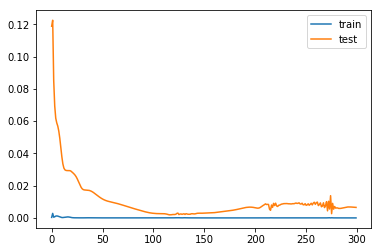

Test RMSE: 0.081


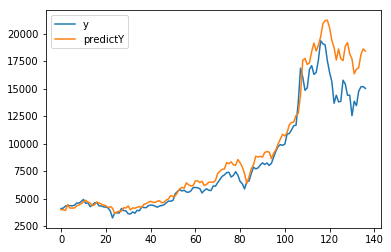

Lookback 1, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


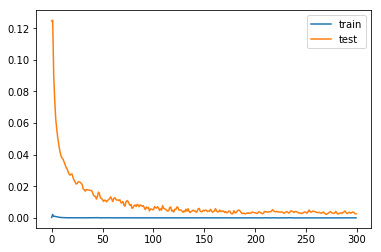

Test RMSE: 0.052


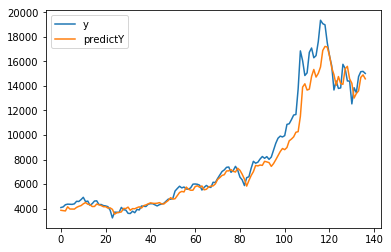

Lookback 1, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


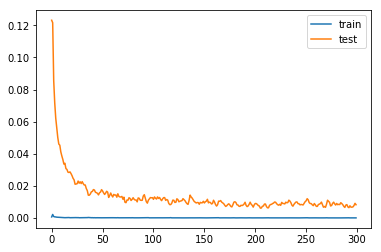

Test RMSE: 0.091


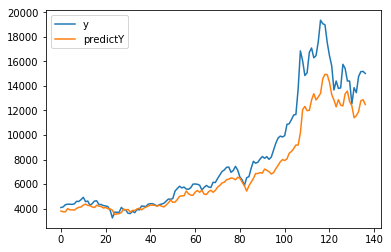

Lookback 1, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


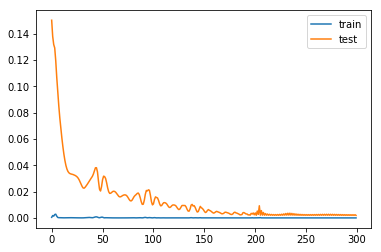

Test RMSE: 0.044


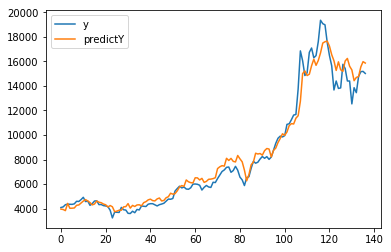

Lookback 1, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


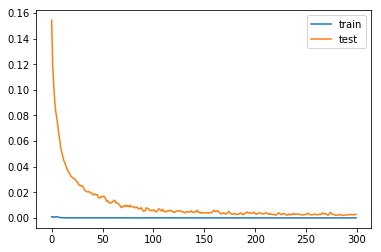

Test RMSE: 0.053


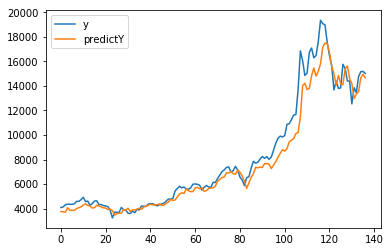

Lookback 1, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


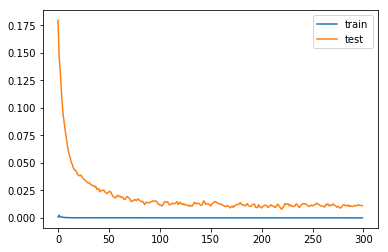

Test RMSE: 0.105


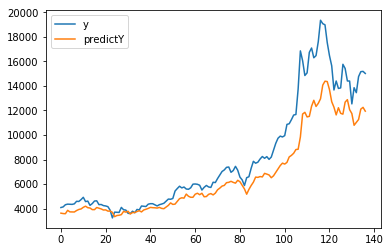

Lookback 1, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


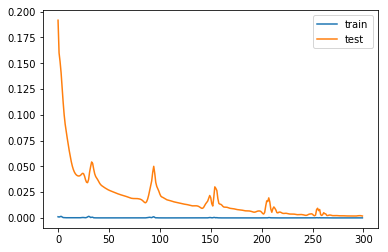

Test RMSE: 0.043


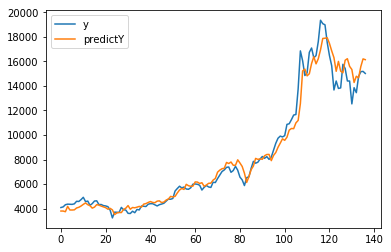

Lookback 1, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


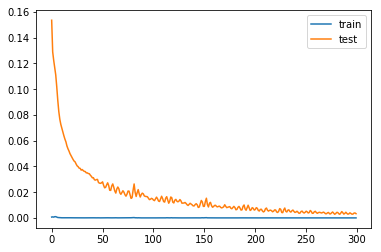

Test RMSE: 0.058


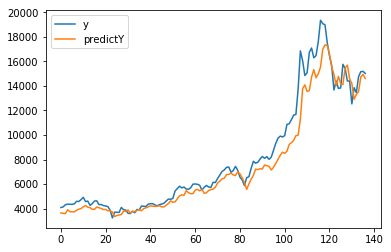

Lookback 1, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


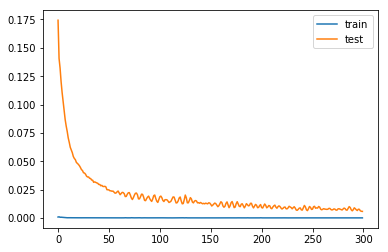

Test RMSE: 0.076


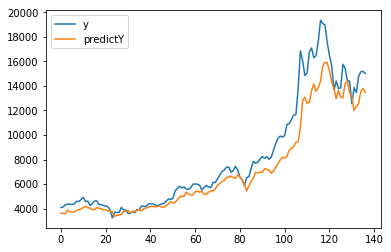

Lookback 1, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


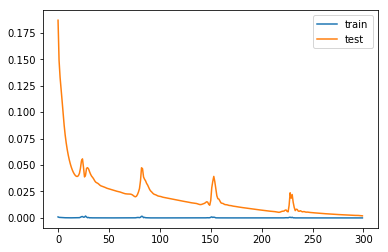

Test RMSE: 0.044


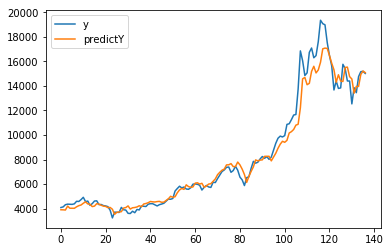

Lookback 1, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


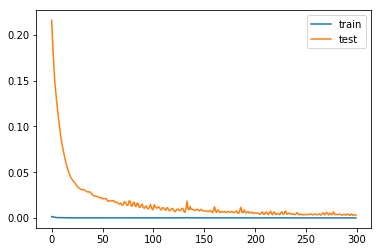

Test RMSE: 0.054


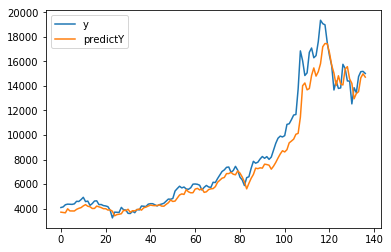

Lookback 1, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


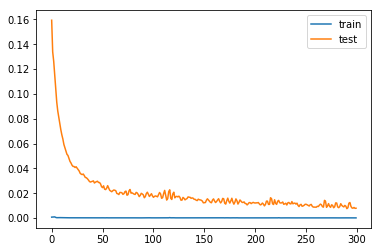

Test RMSE: 0.089


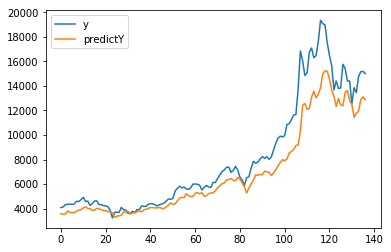

Lookback 1, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


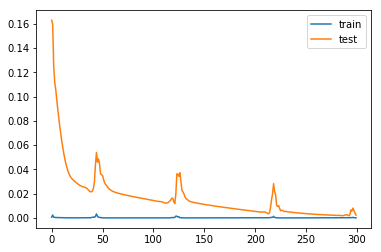

Test RMSE: 0.048


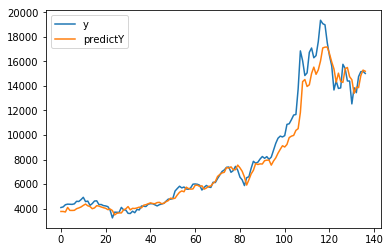

Lookback 1, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


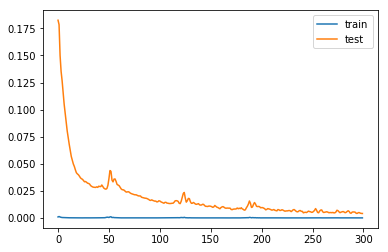

Test RMSE: 0.064


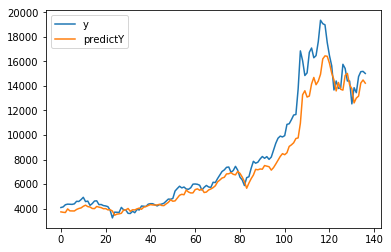

Lookback 1, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


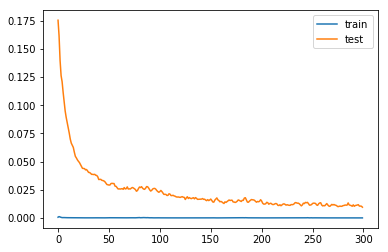

Test RMSE: 0.098


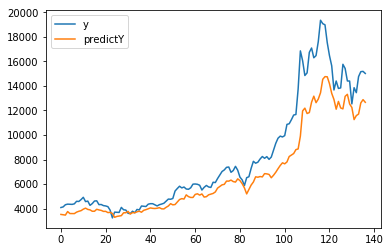

Lookback 1, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


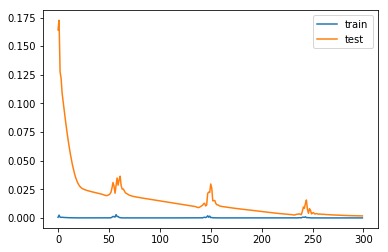

Test RMSE: 0.042


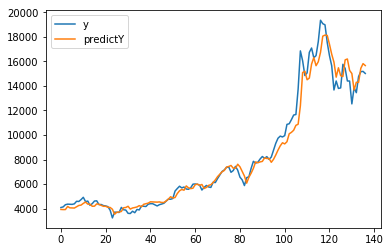

Lookback 1, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


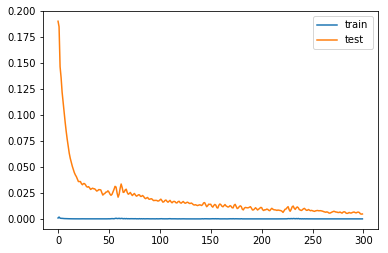

Test RMSE: 0.069


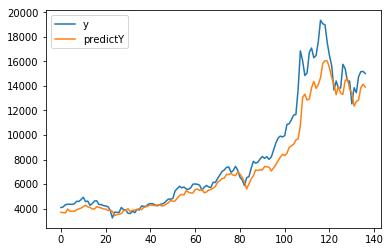

Lookback 1, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


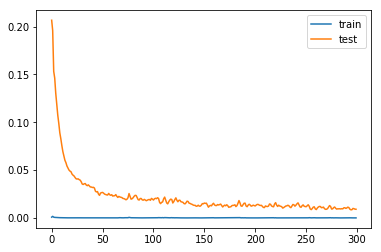

Test RMSE: 0.096


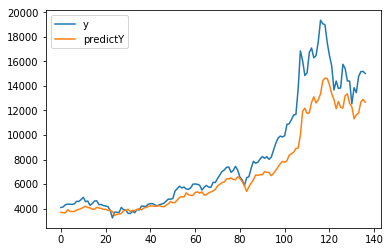

Lookback 1, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


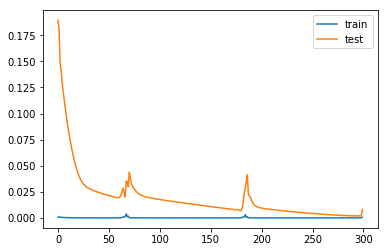

Test RMSE: 0.091


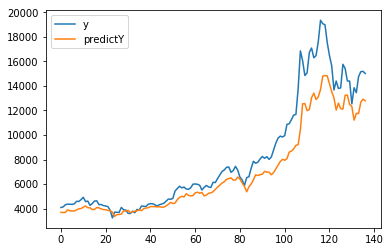

Lookback 1, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


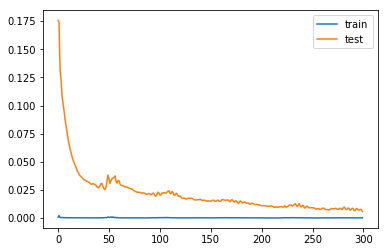

Test RMSE: 0.077


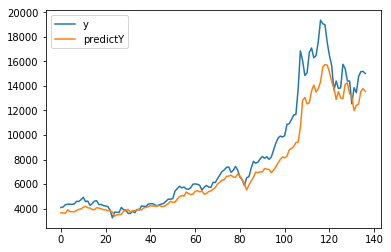

Lookback 1, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


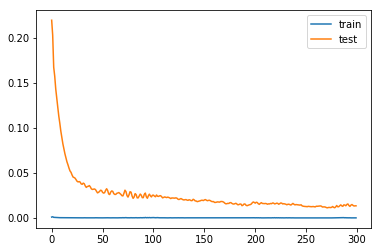

Test RMSE: 0.116


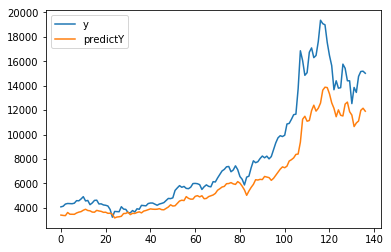

Lookback 1, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


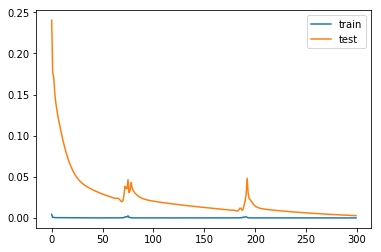

Test RMSE: 0.053


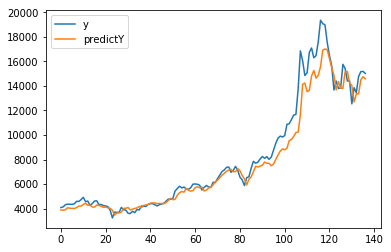

Lookback 1, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


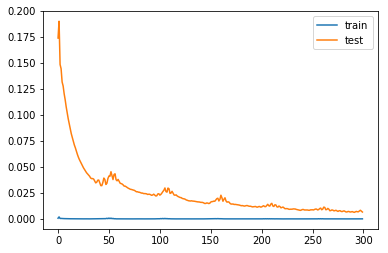

Test RMSE: 0.082


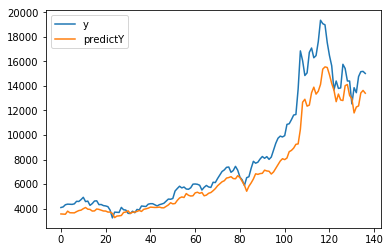

Lookback 1, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


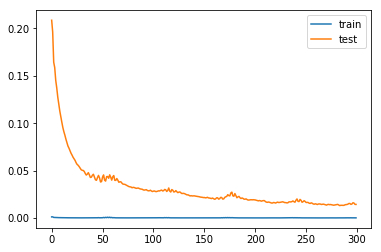

Test RMSE: 0.120


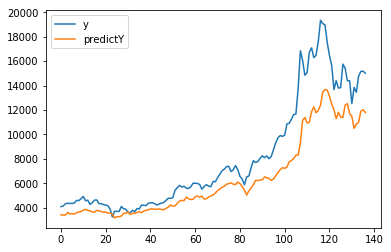

Lookback 1, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


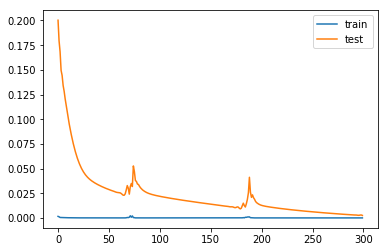

Test RMSE: 0.050


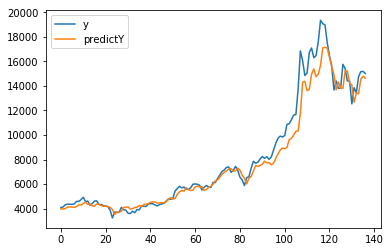

Lookback 1, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


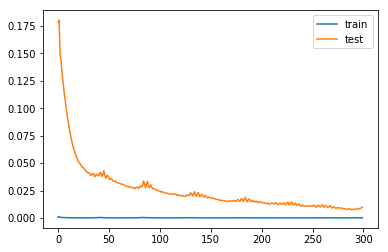

Test RMSE: 0.099


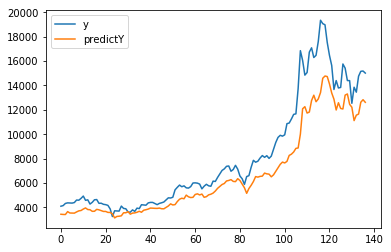

Lookback 1, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


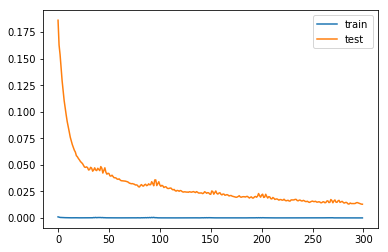

Test RMSE: 0.114


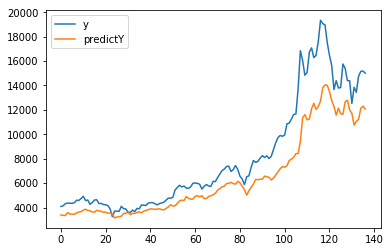

Lookback 1, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


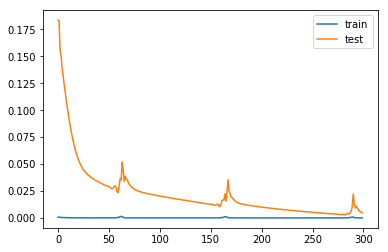

Test RMSE: 0.070


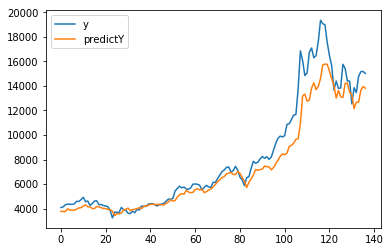

Lookback 1, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


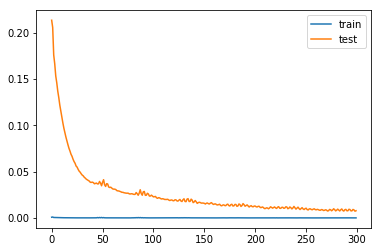

Test RMSE: 0.088


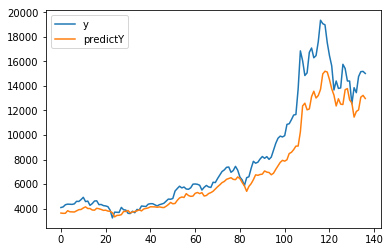

Lookback 1, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


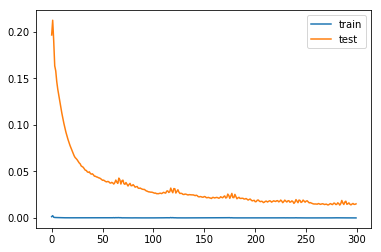

Test RMSE: 0.123


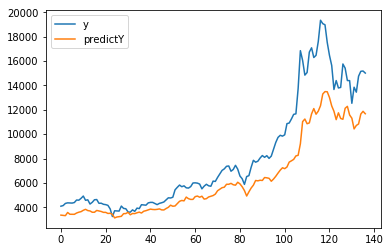

Lookback 2, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


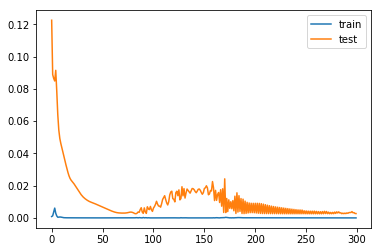

Test RMSE: 0.052


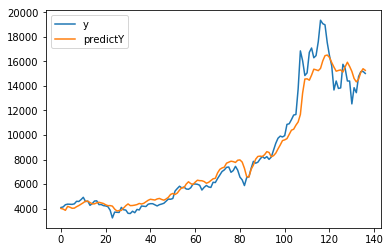

Lookback 2, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


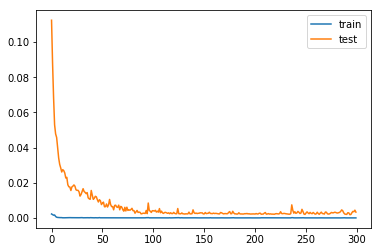

Test RMSE: 0.058


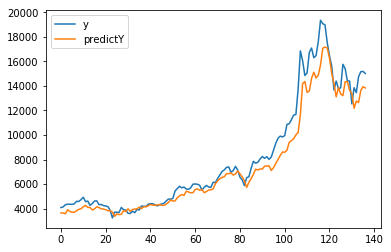

Lookback 2, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


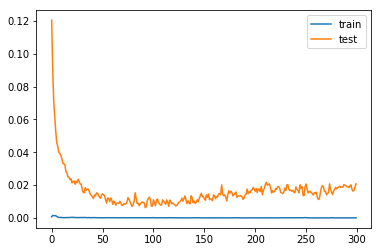

Test RMSE: 0.144


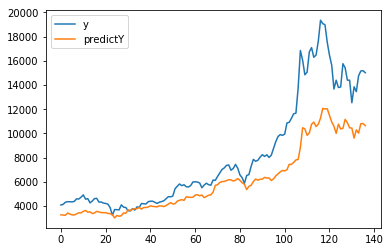

Lookback 2, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


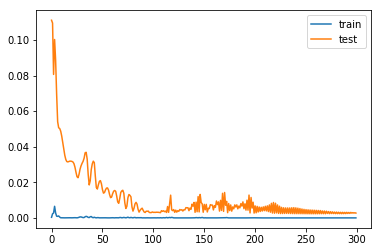

Test RMSE: 0.052


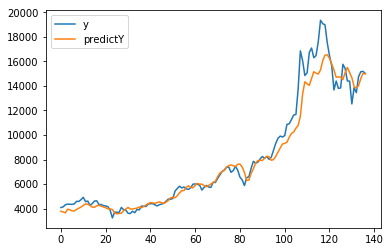

Lookback 2, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


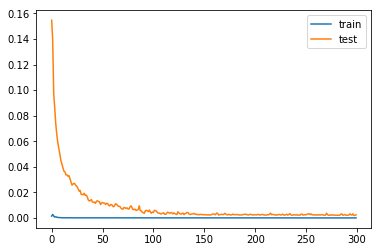

Test RMSE: 0.050


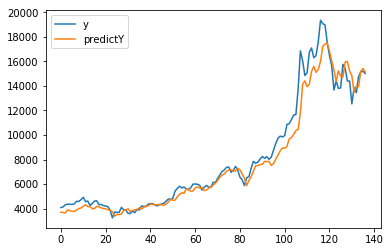

Lookback 2, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


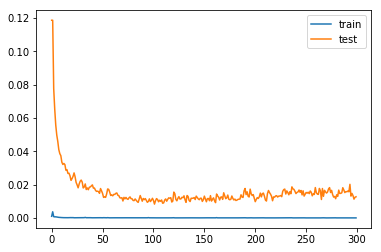

Test RMSE: 0.113


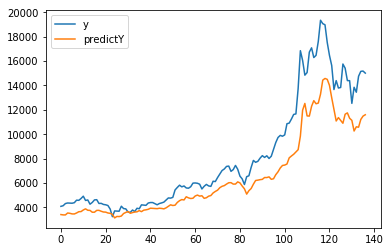

Lookback 2, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


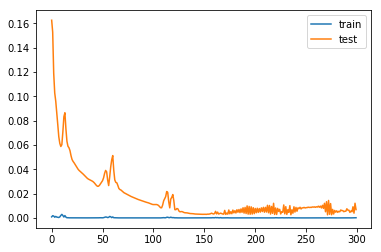

Test RMSE: 0.083


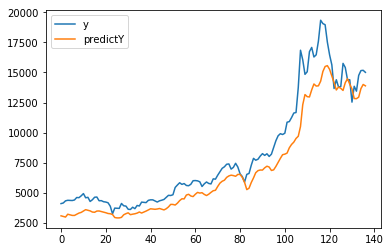

Lookback 2, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


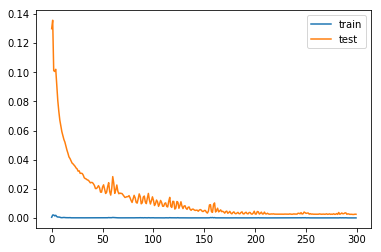

Test RMSE: 0.050


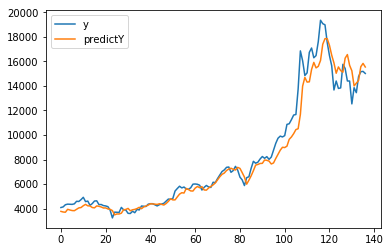

Lookback 2, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


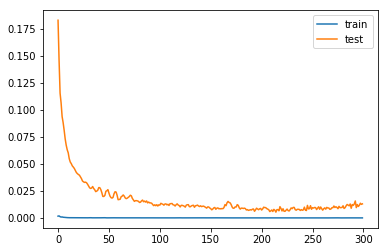

Test RMSE: 0.114


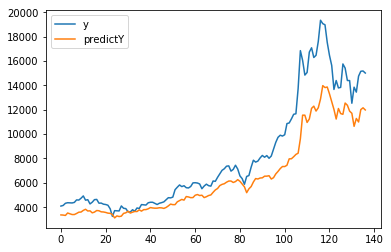

Lookback 2, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


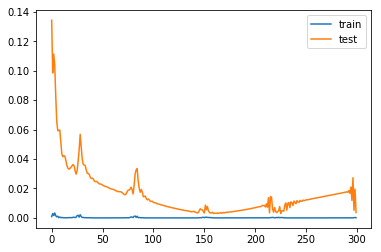

Test RMSE: 0.061


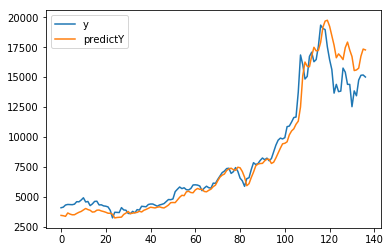

Lookback 2, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


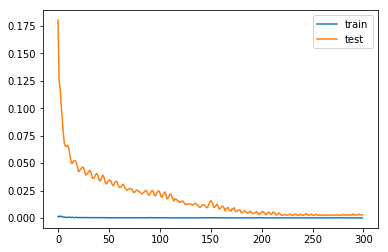

Test RMSE: 0.053


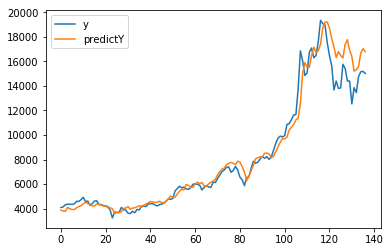

Lookback 2, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


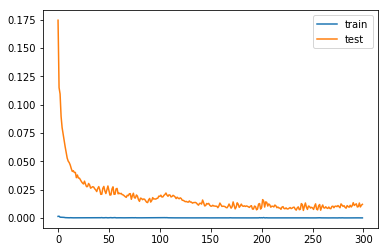

Test RMSE: 0.110


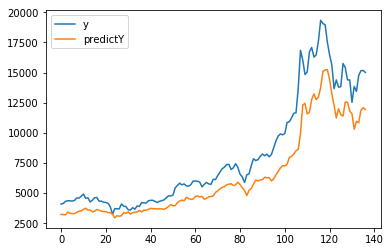

Lookback 2, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


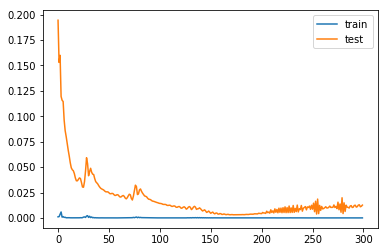

Test RMSE: 0.112


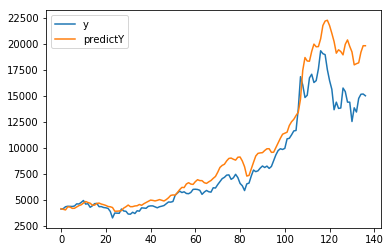

Lookback 2, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


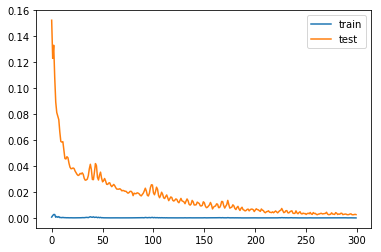

Test RMSE: 0.051


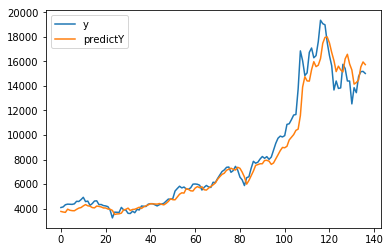

Lookback 2, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


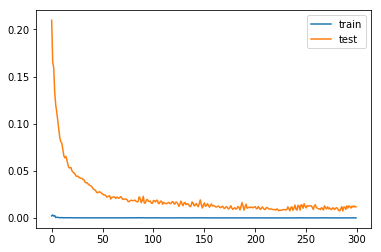

Test RMSE: 0.109


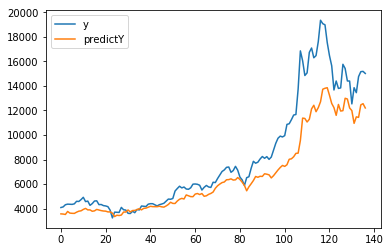

Lookback 2, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


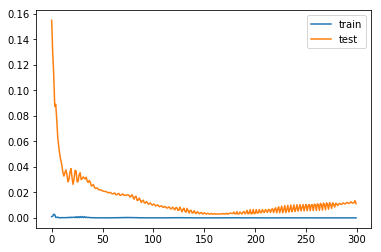

Test RMSE: 0.106


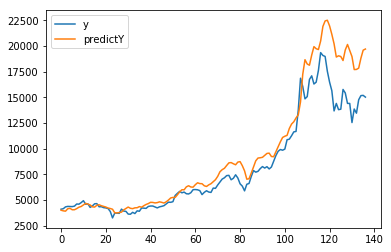

Lookback 2, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


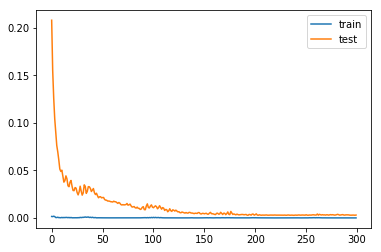

Test RMSE: 0.055


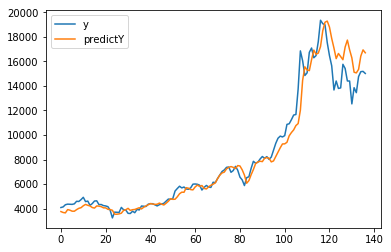

Lookback 2, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


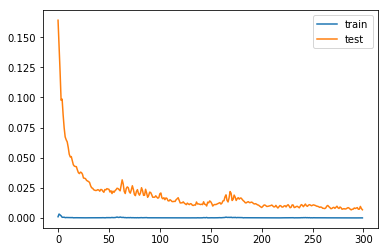

Test RMSE: 0.083


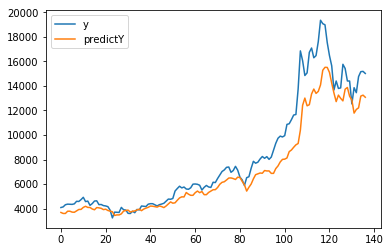

Lookback 2, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


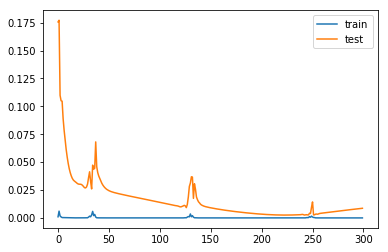

Test RMSE: 0.093


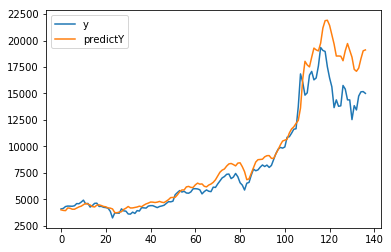

Lookback 2, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


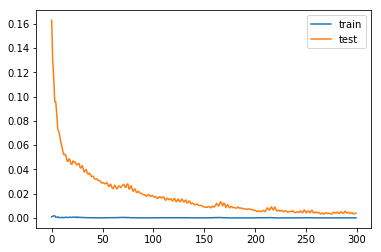

Test RMSE: 0.064


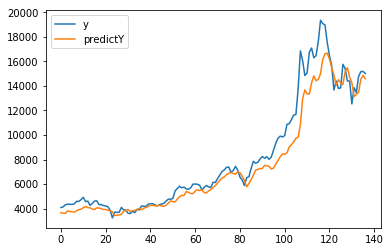

Lookback 2, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


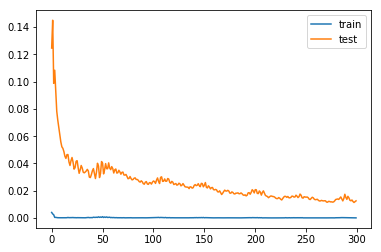

Test RMSE: 0.112


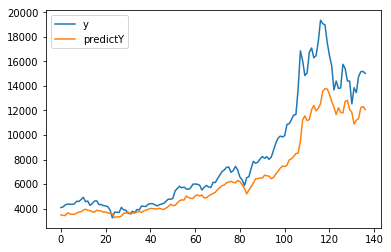

Lookback 2, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


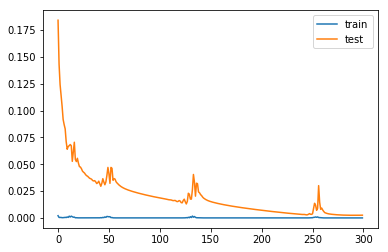

Test RMSE: 0.050


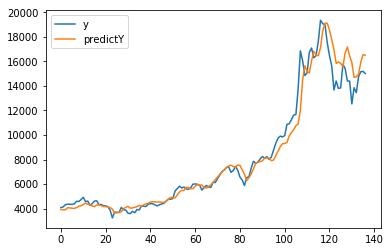

Lookback 2, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


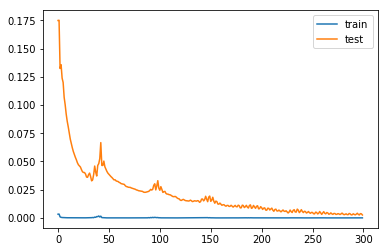

Test RMSE: 0.051


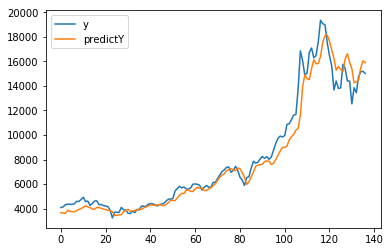

Lookback 2, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


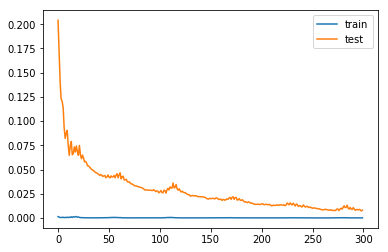

Test RMSE: 0.089


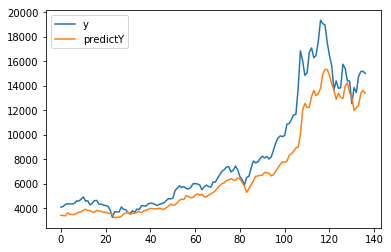

Lookback 2, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


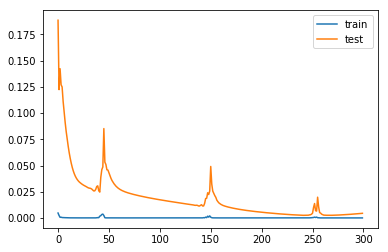

Test RMSE: 0.066


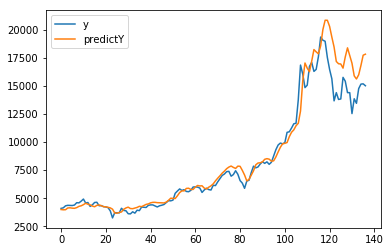

Lookback 2, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


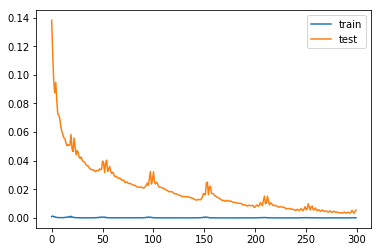

Test RMSE: 0.075


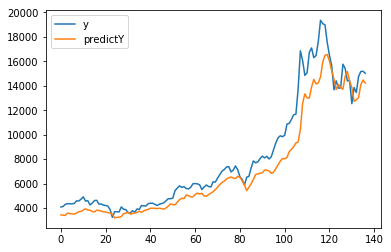

Lookback 2, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


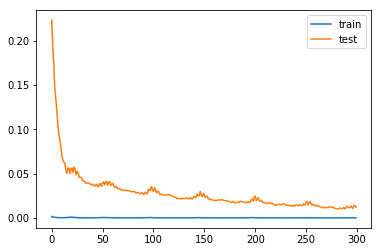

Test RMSE: 0.110


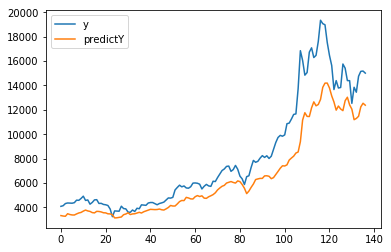

Lookback 2, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


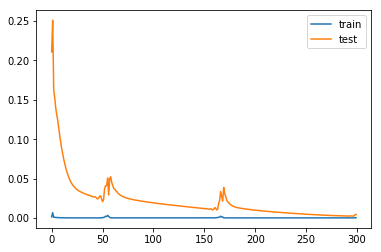

Test RMSE: 0.066


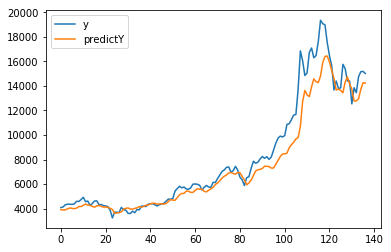

Lookback 2, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


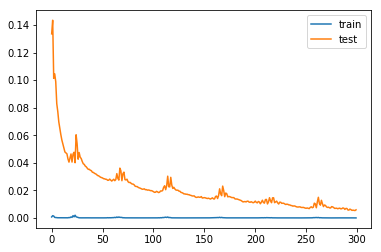

Test RMSE: 0.077


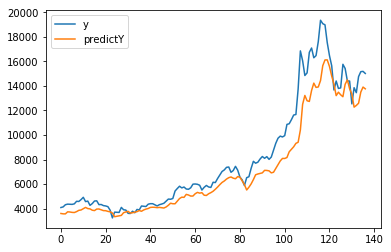

Lookback 2, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


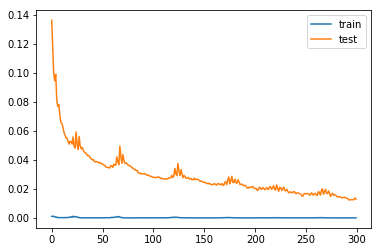

Test RMSE: 0.114


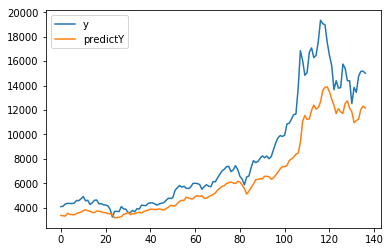

Lookback 3, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


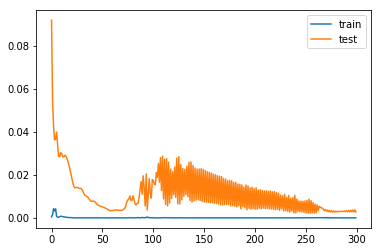

Test RMSE: 0.052


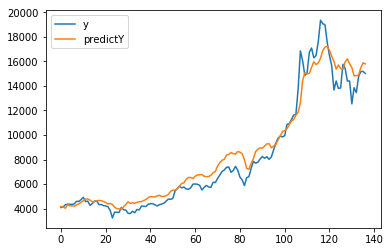

Lookback 3, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


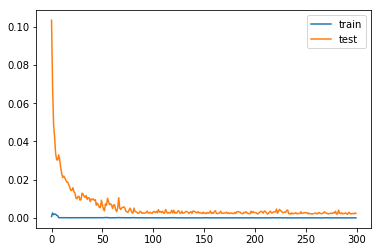

Test RMSE: 0.049


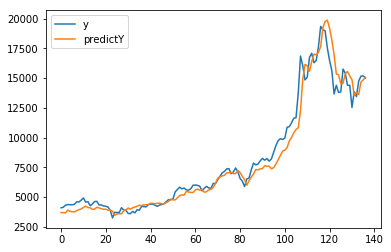

Lookback 3, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


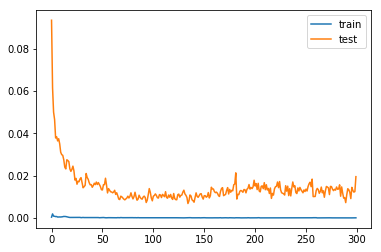

Test RMSE: 0.140


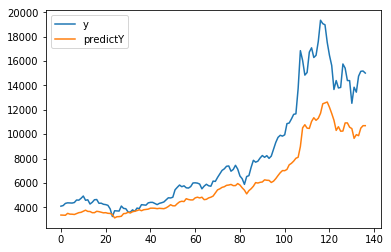

Lookback 3, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


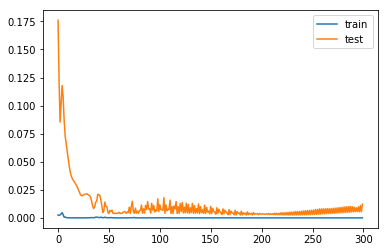

Test RMSE: 0.111


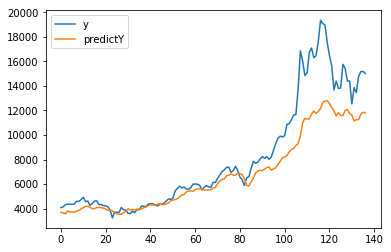

Lookback 3, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


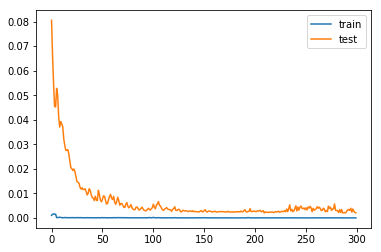

Test RMSE: 0.046


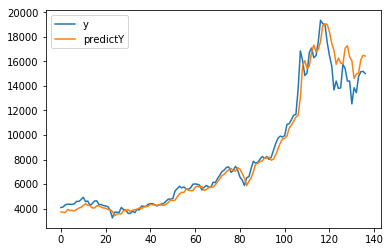

Lookback 3, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


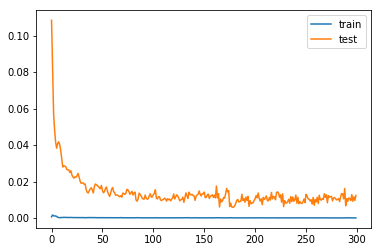

Test RMSE: 0.111


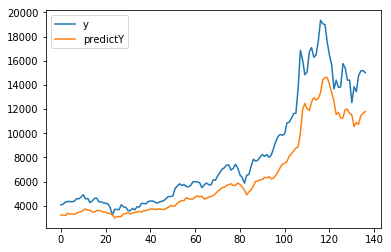

Lookback 3, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


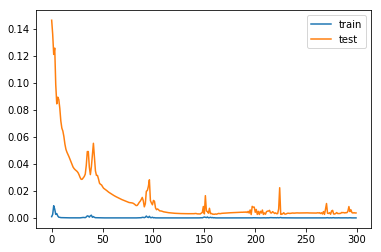

Test RMSE: 0.061


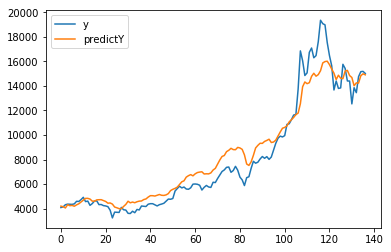

Lookback 3, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


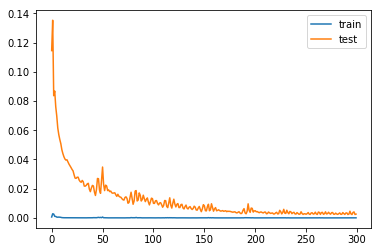

Test RMSE: 0.051


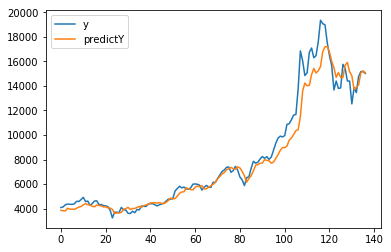

Lookback 3, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


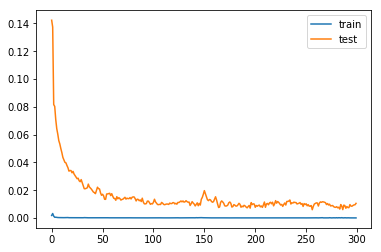

Test RMSE: 0.103


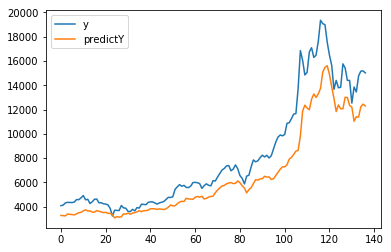

Lookback 3, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


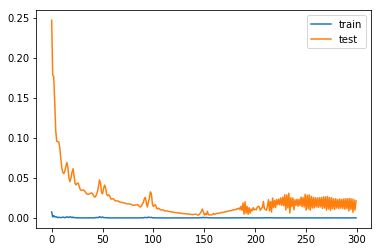

Test RMSE: 0.147


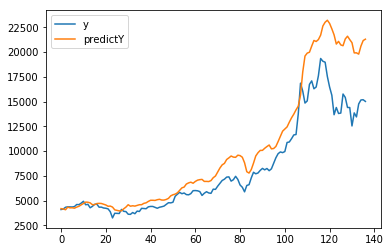

Lookback 3, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


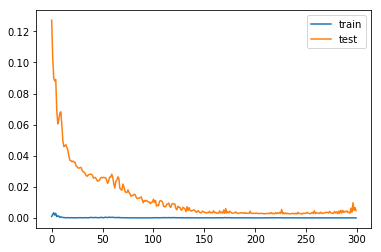

Test RMSE: 0.069


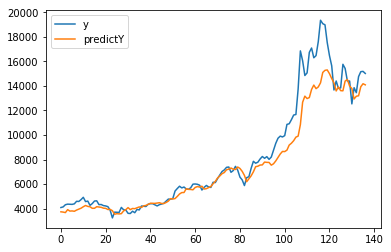

Lookback 3, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


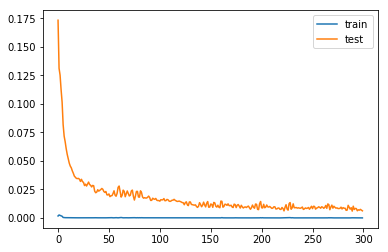

Test RMSE: 0.079


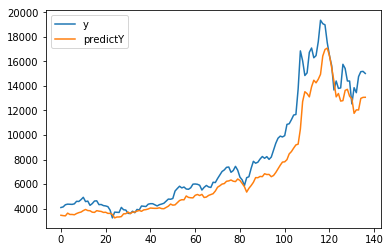

Lookback 3, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


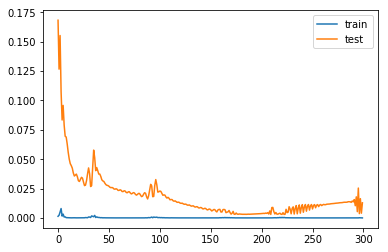

Test RMSE: 0.113


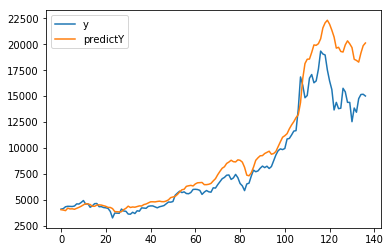

Lookback 3, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


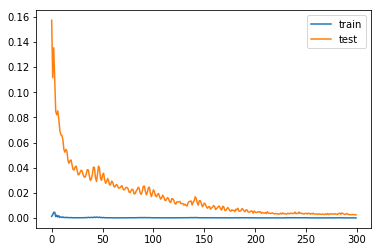

Test RMSE: 0.050


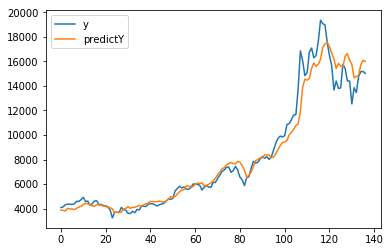

Lookback 3, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


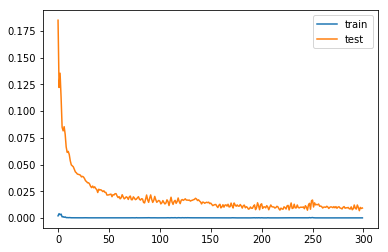

Test RMSE: 0.096


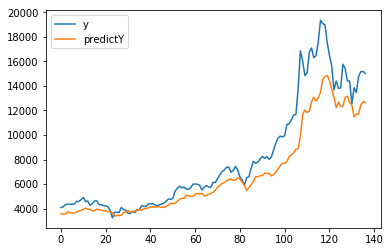

Lookback 3, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


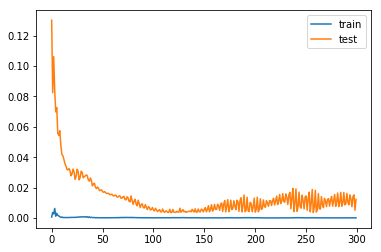

Test RMSE: 0.111


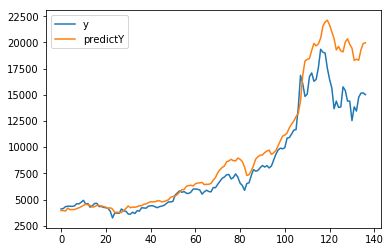

Lookback 3, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


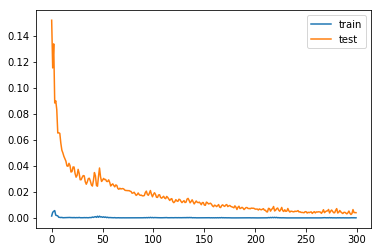

Test RMSE: 0.064


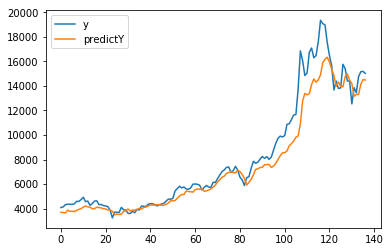

Lookback 3, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


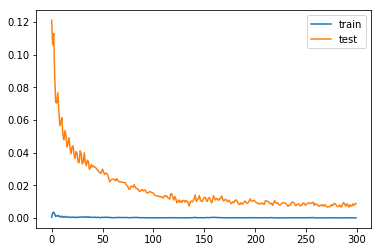

Test RMSE: 0.095


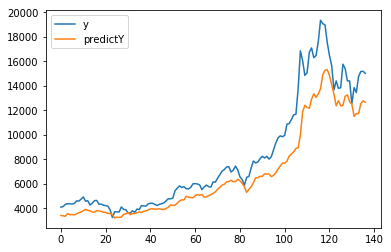

Lookback 3, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


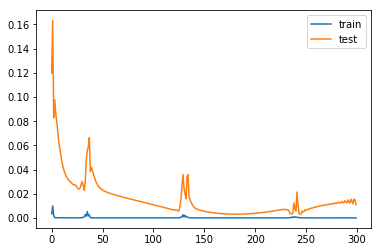

Test RMSE: 0.104


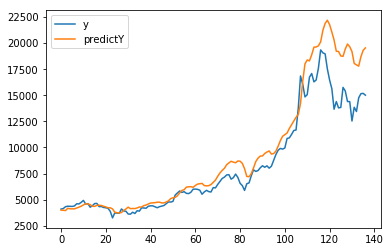

Lookback 3, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


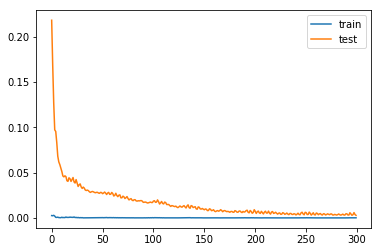

Test RMSE: 0.054


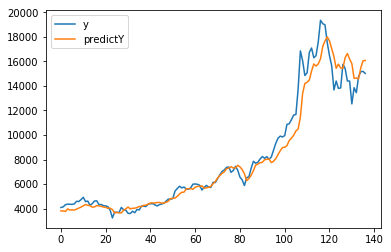

Lookback 3, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


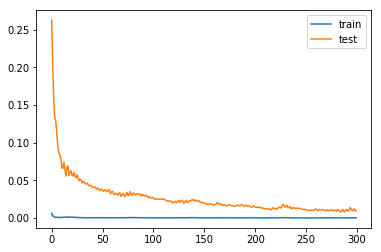

Test RMSE: 0.097


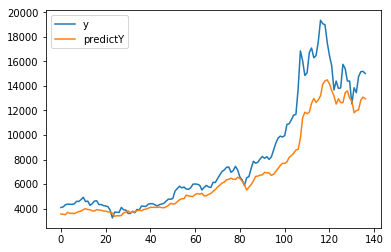

Lookback 3, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


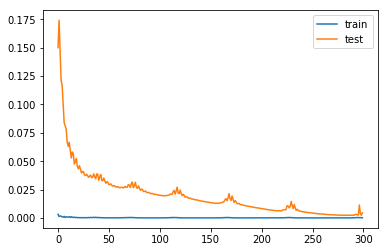

Test RMSE: 0.068


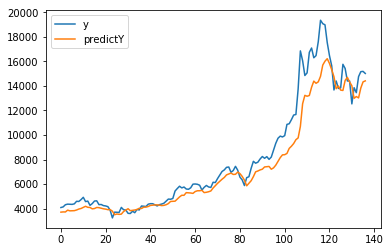

Lookback 3, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


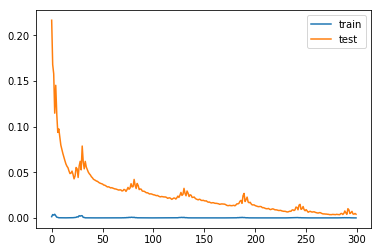

Test RMSE: 0.064


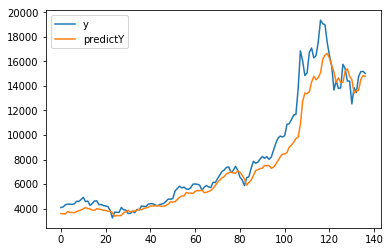

Lookback 3, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


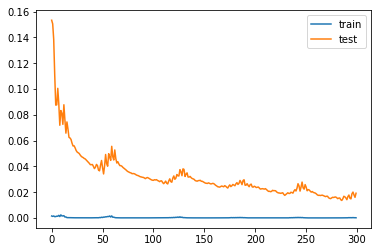

Test RMSE: 0.139


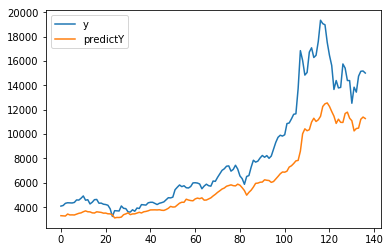

Lookback 3, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


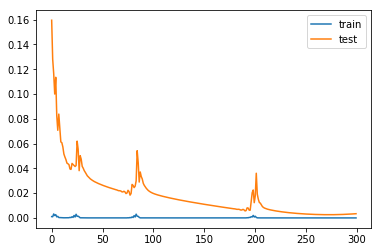

Test RMSE: 0.058


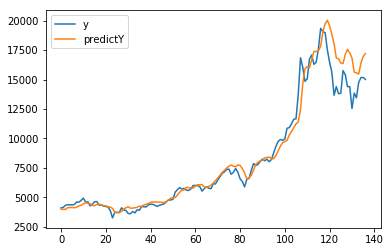

Lookback 3, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


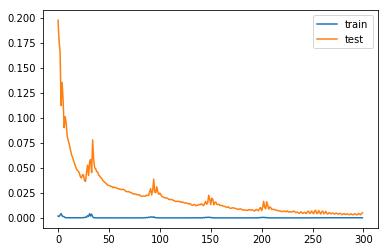

Test RMSE: 0.072


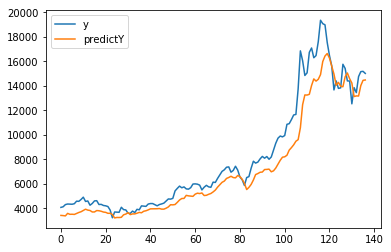

Lookback 3, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


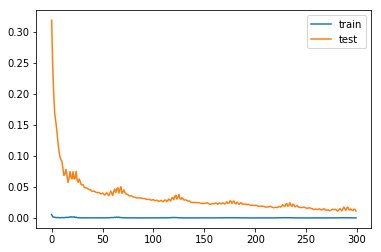

Test RMSE: 0.105


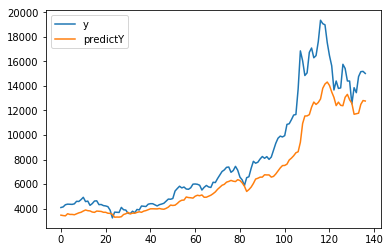

Lookback 3, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


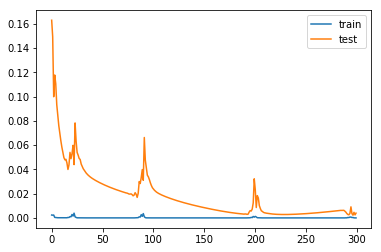

Test RMSE: 0.063


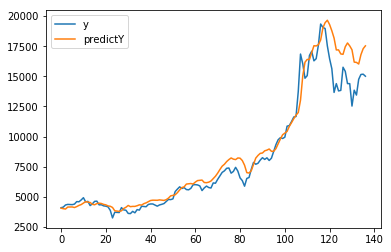

Lookback 3, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


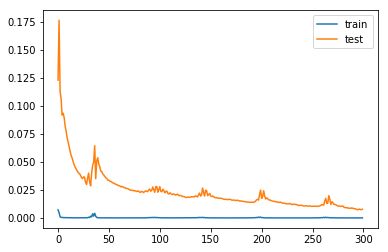

Test RMSE: 0.088


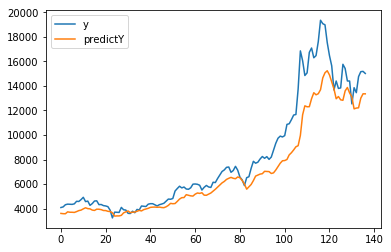

Lookback 3, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


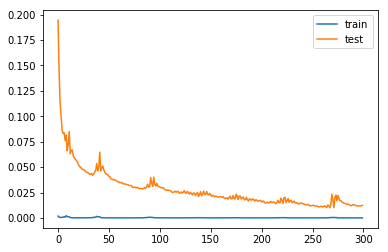

Test RMSE: 0.111


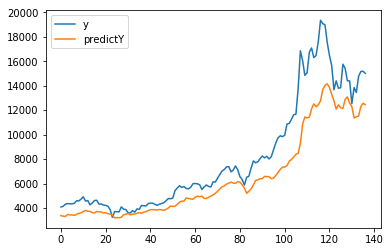

Lookback 4, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


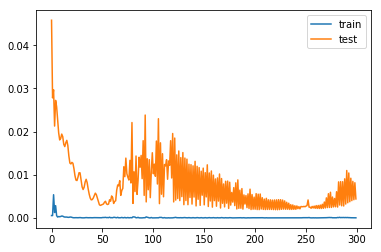

Test RMSE: 0.066


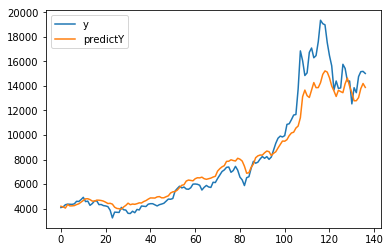

Lookback 4, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


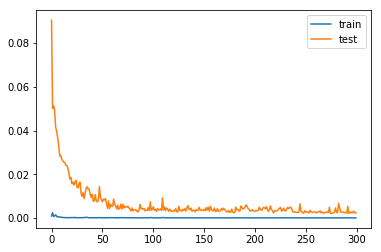

Test RMSE: 0.048


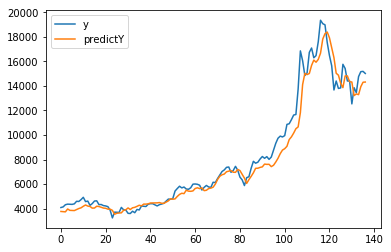

Lookback 4, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


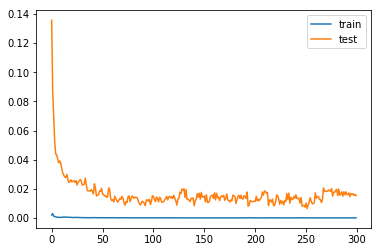

Test RMSE: 0.124


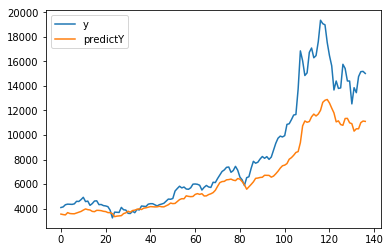

Lookback 4, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


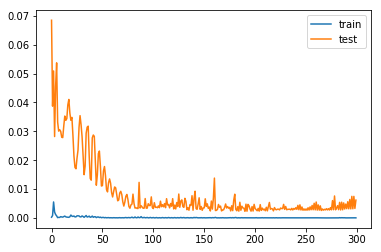

Test RMSE: 0.079


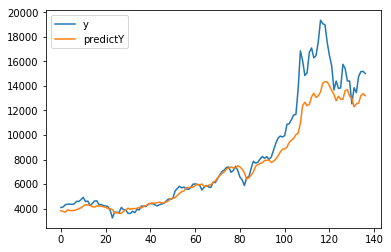

Lookback 4, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


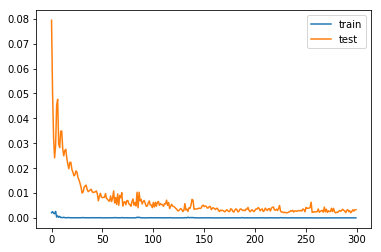

Test RMSE: 0.058


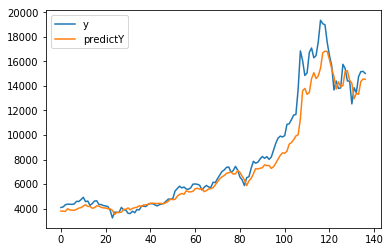

Lookback 4, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


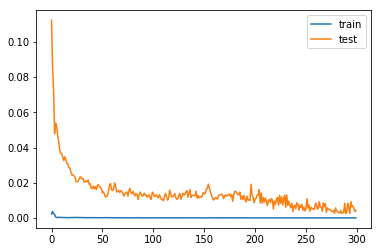

Test RMSE: 0.066


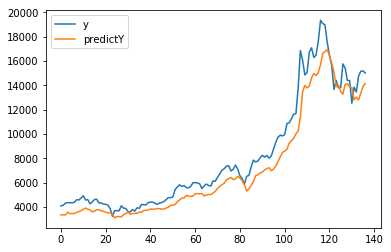

Lookback 4, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


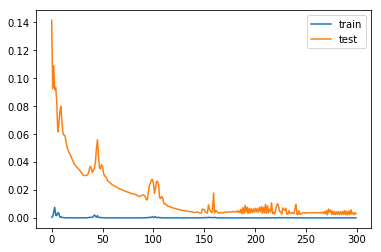

Test RMSE: 0.054


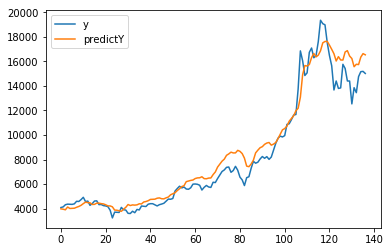

Lookback 4, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


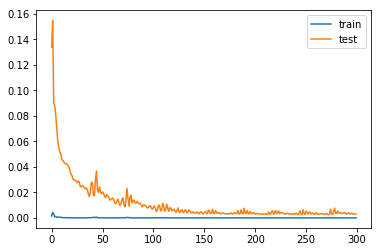

Test RMSE: 0.054


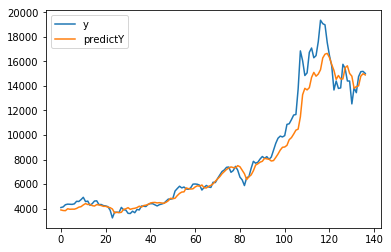

Lookback 4, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


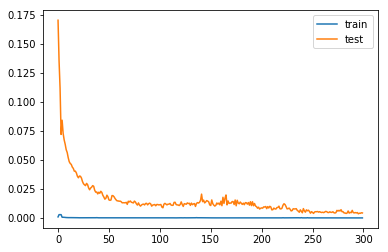

Test RMSE: 0.066


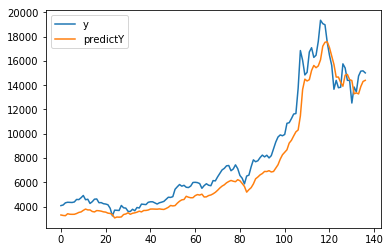

Lookback 4, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


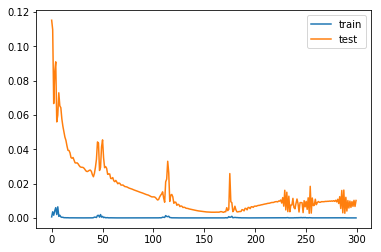

Test RMSE: 0.101


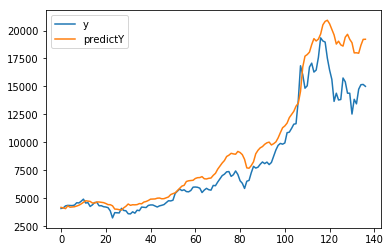

Lookback 4, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


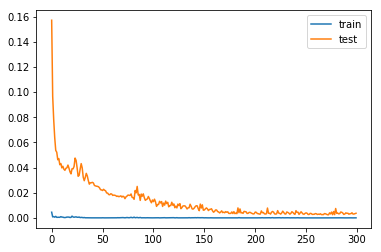

Test RMSE: 0.061


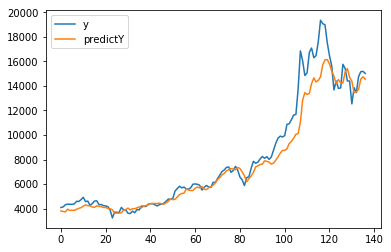

Lookback 4, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


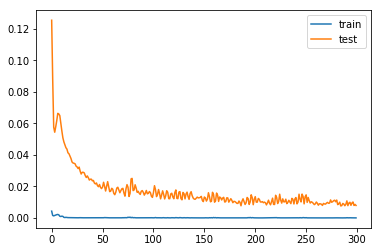

Test RMSE: 0.089


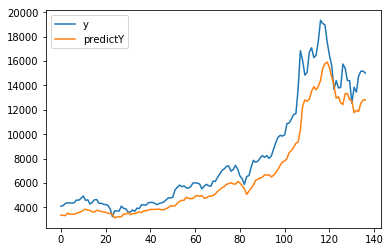

Lookback 4, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


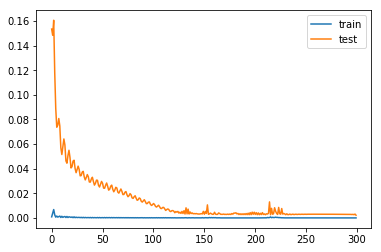

Test RMSE: 0.047


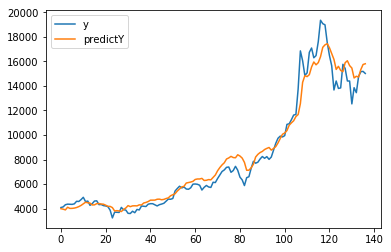

Lookback 4, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


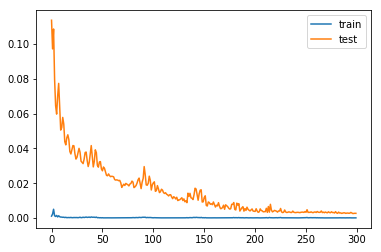

Test RMSE: 0.052


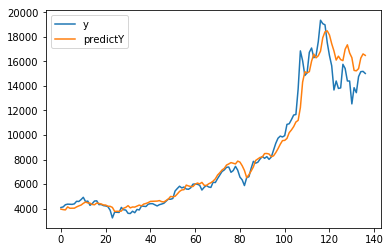

Lookback 4, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


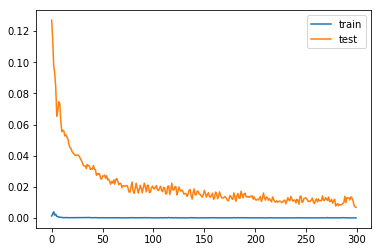

Test RMSE: 0.083


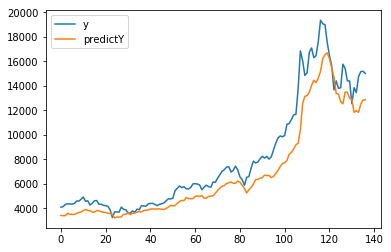

Lookback 4, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


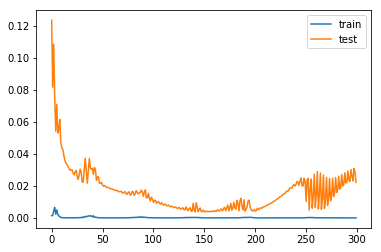

Test RMSE: 0.149


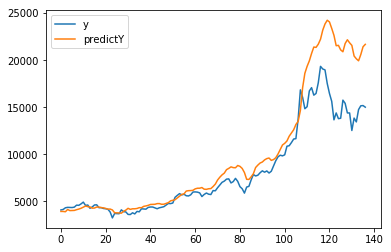

Lookback 4, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


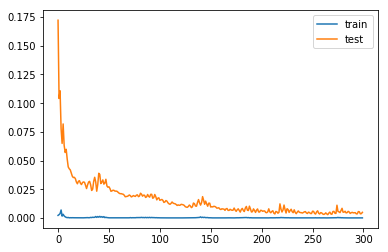

Test RMSE: 0.070


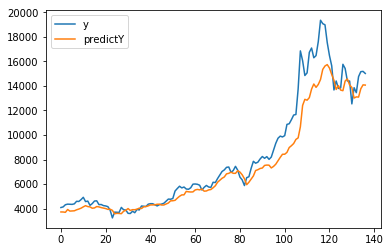

Lookback 4, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


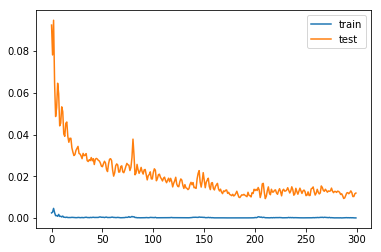

Test RMSE: 0.109


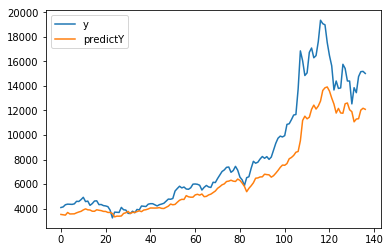

Lookback 4, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


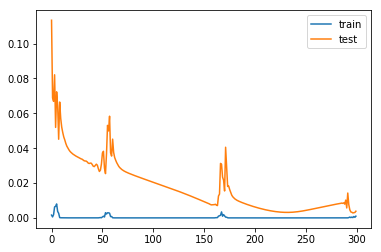

Test RMSE: 0.062


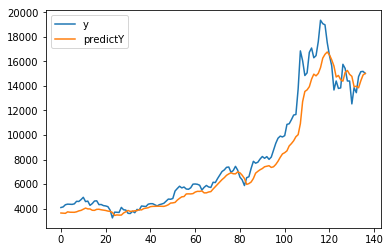

Lookback 4, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


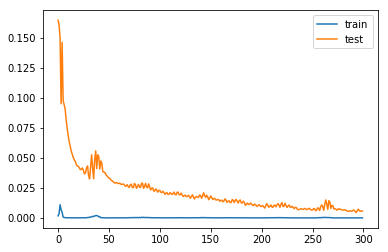

Test RMSE: 0.076


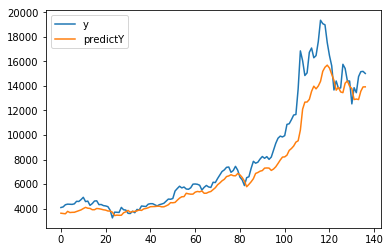

Lookback 4, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


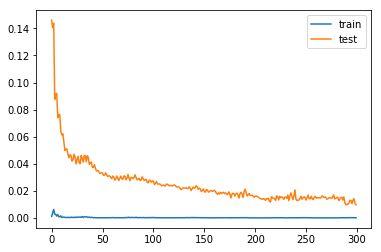

Test RMSE: 0.099


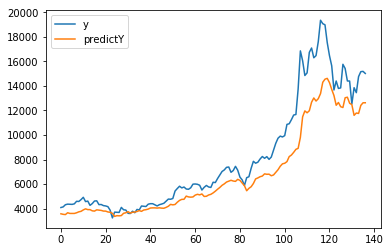

Lookback 4, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


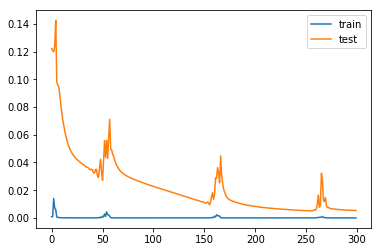

Test RMSE: 0.073


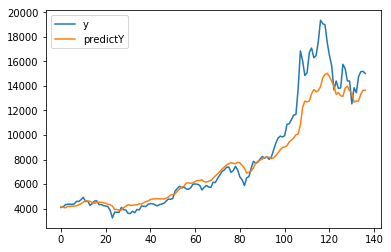

Lookback 4, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


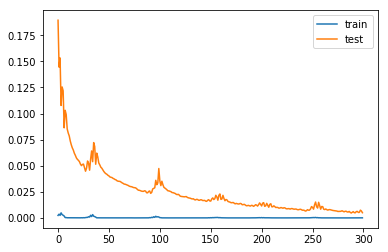

Test RMSE: 0.071


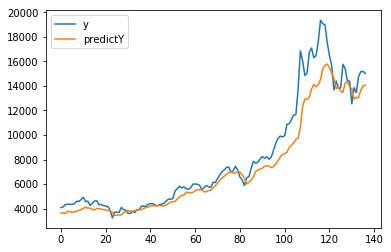

Lookback 4, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


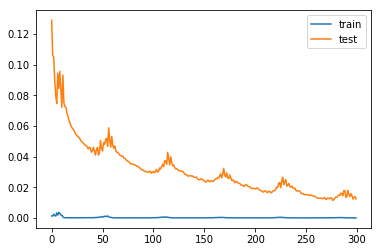

Test RMSE: 0.111


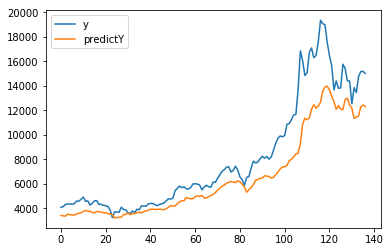

Lookback 4, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


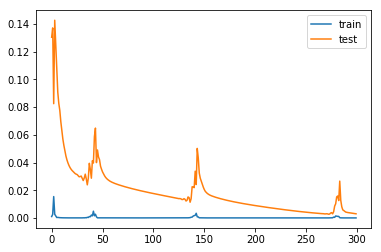

Test RMSE: 0.055


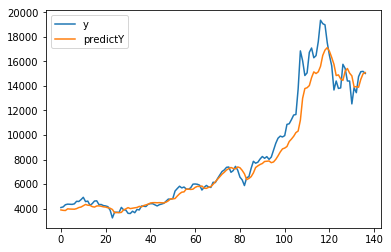

Lookback 4, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


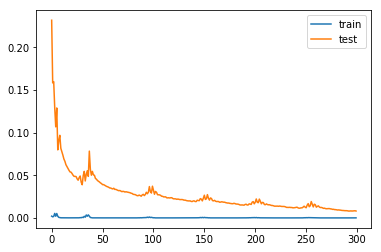

Test RMSE: 0.090


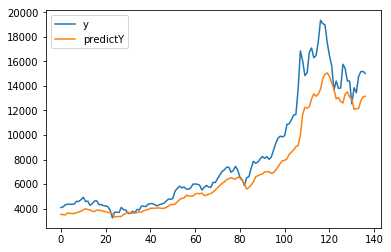

Lookback 4, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


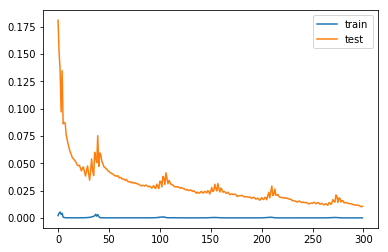

Test RMSE: 0.104


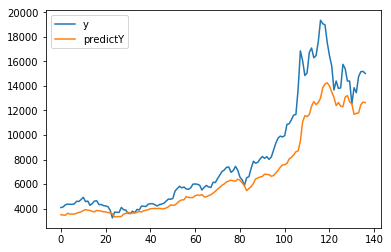

Lookback 4, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


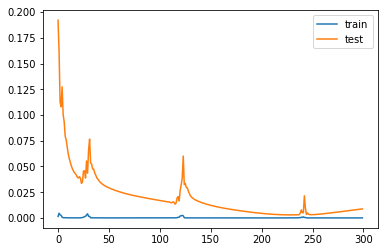

Test RMSE: 0.094


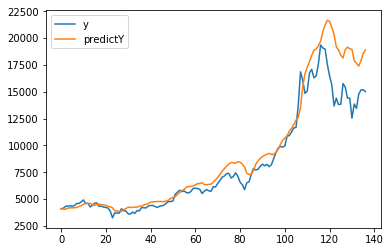

Lookback 4, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


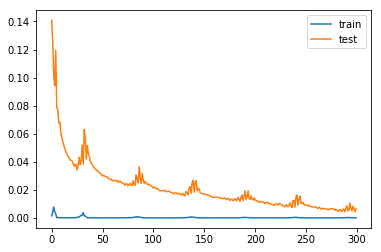

Test RMSE: 0.081


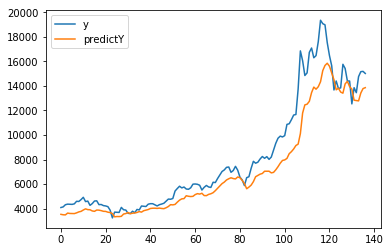

Lookback 4, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


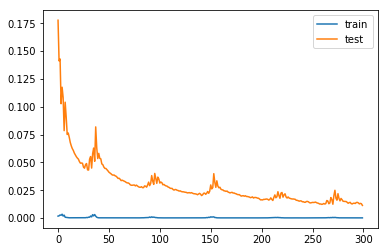

Test RMSE: 0.106


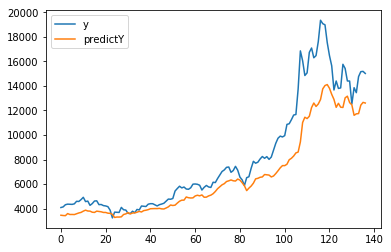

Lookback 5, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


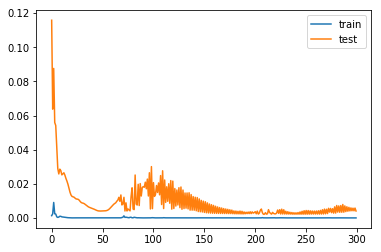

Test RMSE: 0.064


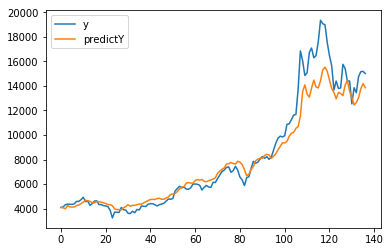

Lookback 5, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


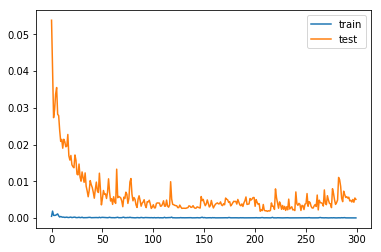

Test RMSE: 0.071


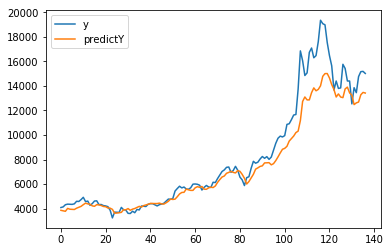

Lookback 5, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


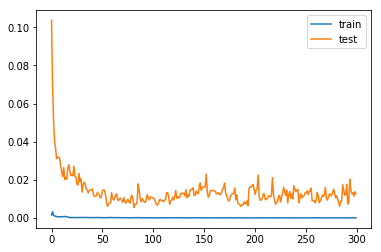

Test RMSE: 0.112


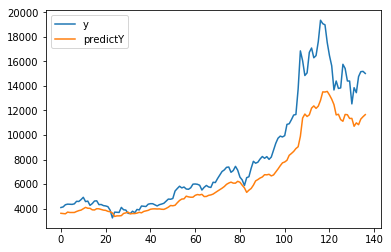

Lookback 5, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


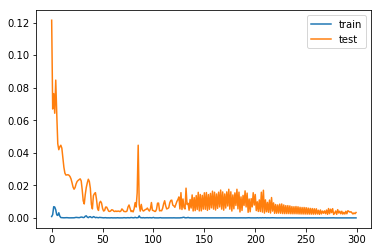

Test RMSE: 0.058


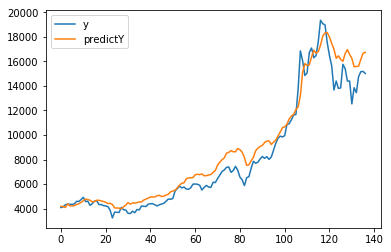

Lookback 5, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


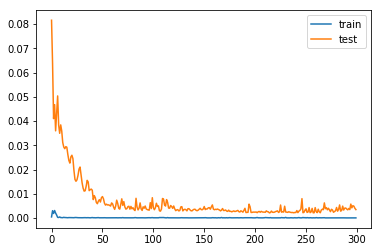

Test RMSE: 0.059


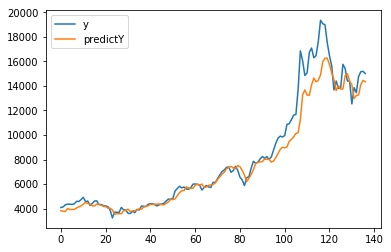

Lookback 5, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


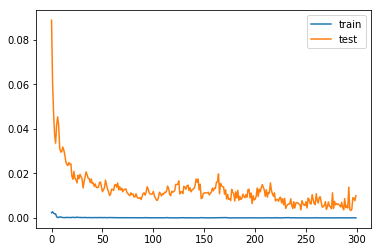

Test RMSE: 0.100


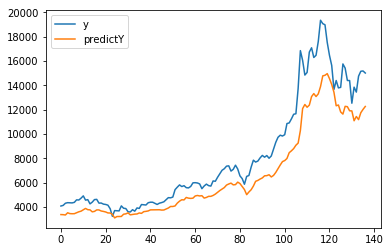

Lookback 5, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


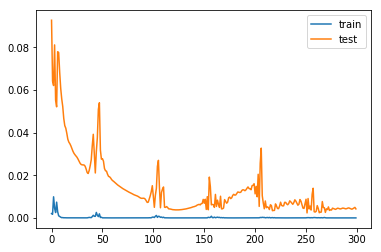

Test RMSE: 0.065


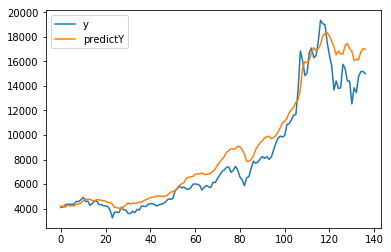

Lookback 5, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


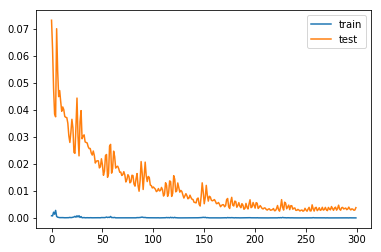

Test RMSE: 0.062


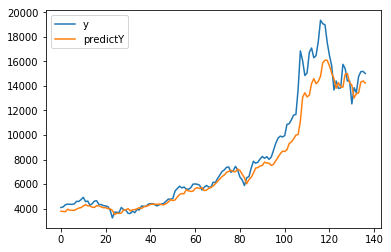

Lookback 5, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


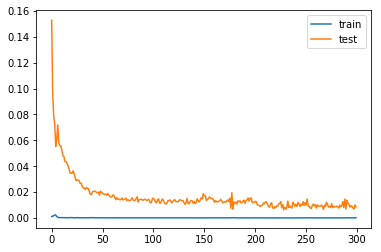

Test RMSE: 0.092


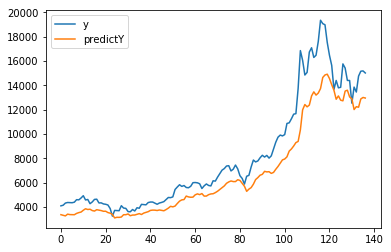

Lookback 5, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


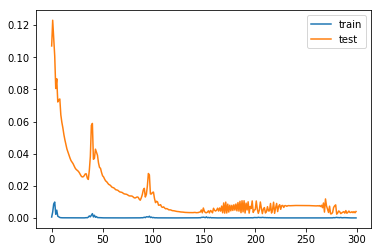

Test RMSE: 0.063


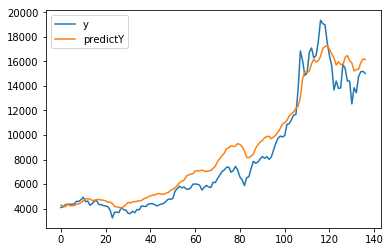

Lookback 5, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


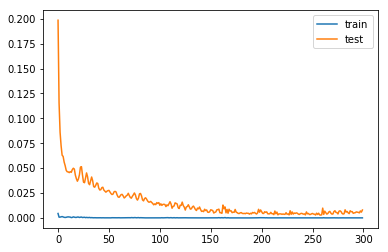

Test RMSE: 0.089


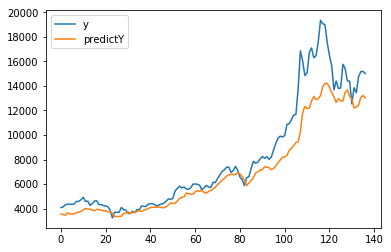

Lookback 5, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


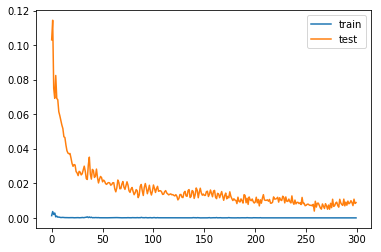

Test RMSE: 0.094


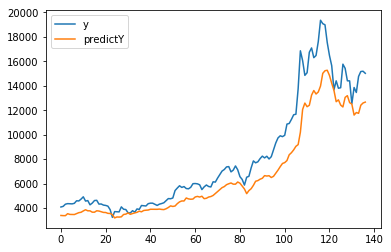

Lookback 5, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


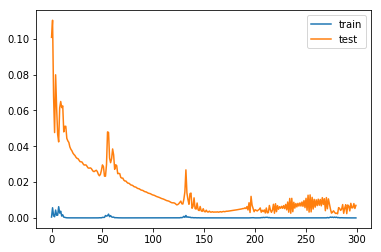

Test RMSE: 0.084


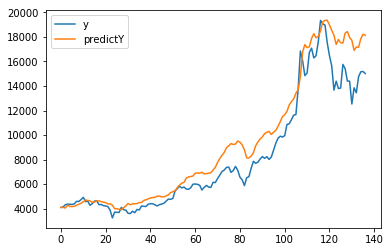

Lookback 5, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


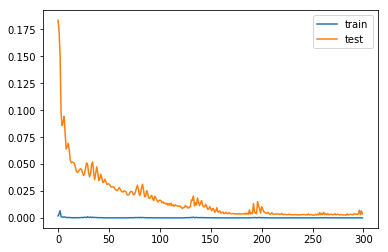

Test RMSE: 0.060


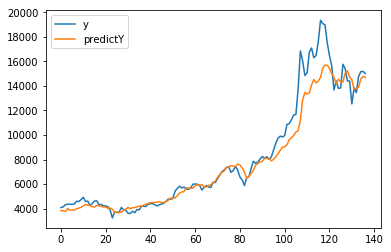

Lookback 5, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


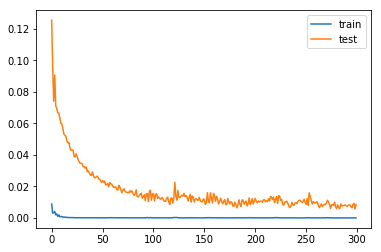

Test RMSE: 0.093


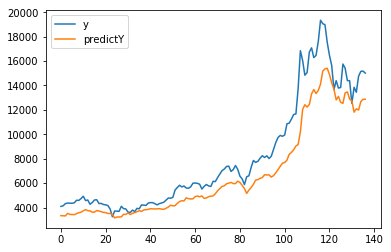

Lookback 5, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


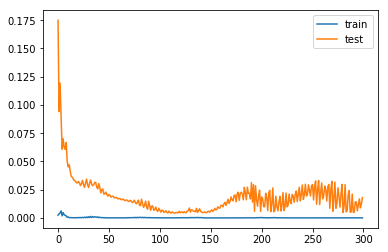

Test RMSE: 0.134


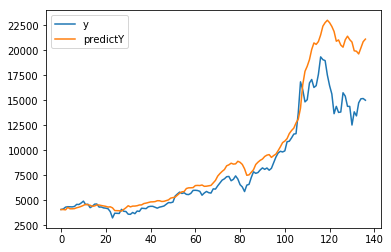

Lookback 5, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


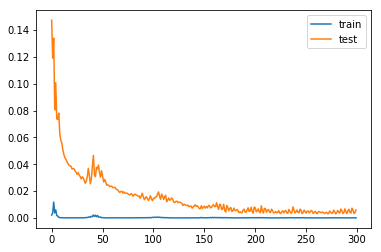

Test RMSE: 0.077


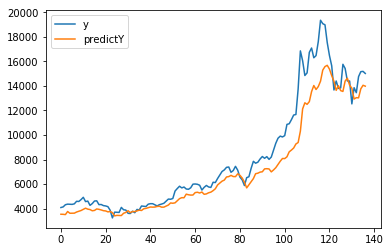

Lookback 5, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


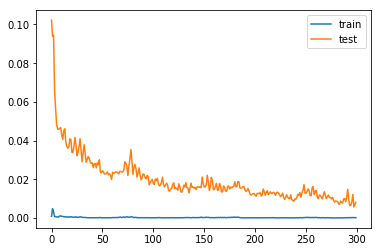

Test RMSE: 0.090


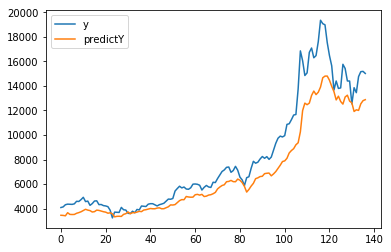

Lookback 5, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


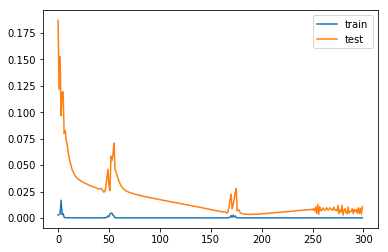

Test RMSE: 0.105


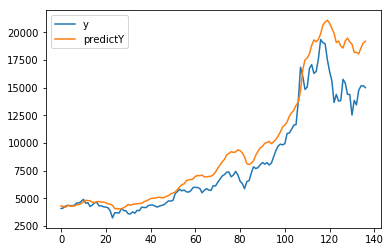

Lookback 5, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


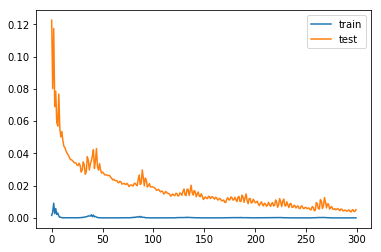

Test RMSE: 0.072


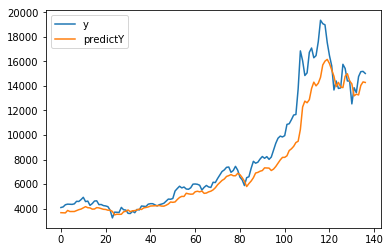

Lookback 5, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


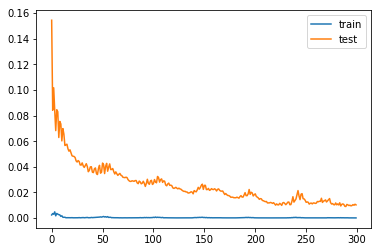

Test RMSE: 0.101


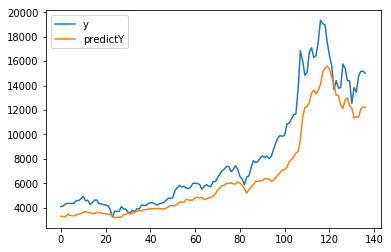

Lookback 5, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


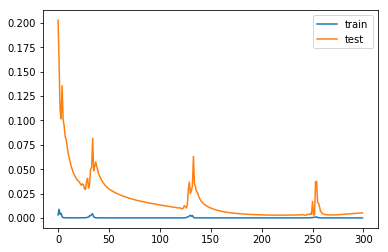

Test RMSE: 0.072


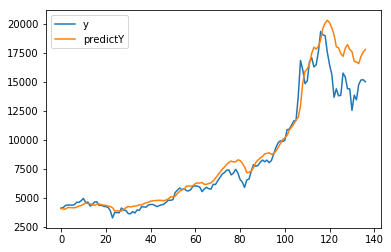

Lookback 5, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


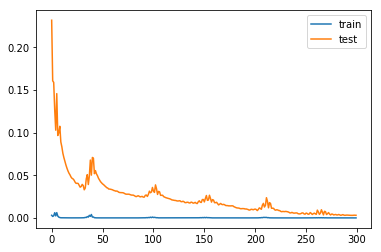

Test RMSE: 0.056


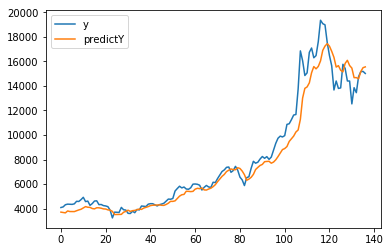

Lookback 5, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


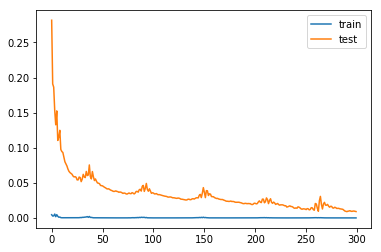

Test RMSE: 0.095


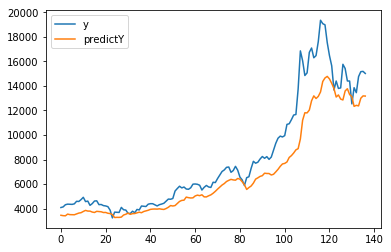

Lookback 5, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


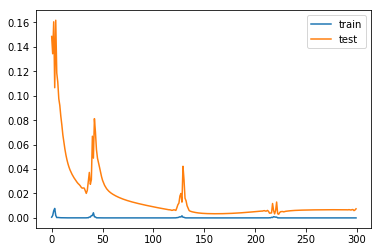

Test RMSE: 0.086


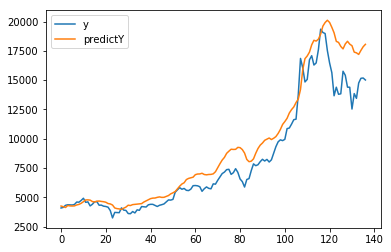

Lookback 5, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


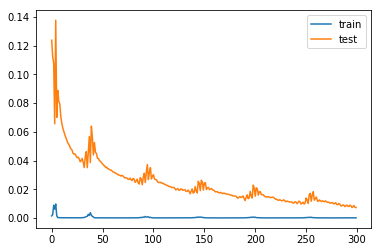

Test RMSE: 0.085


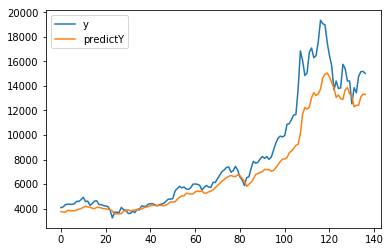

Lookback 5, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


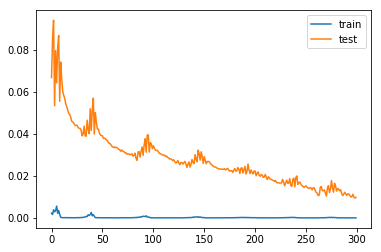

Test RMSE: 0.099


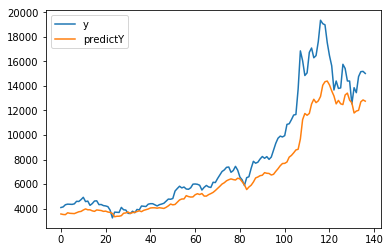

Lookback 5, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


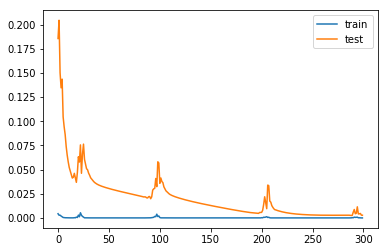

Test RMSE: 0.053


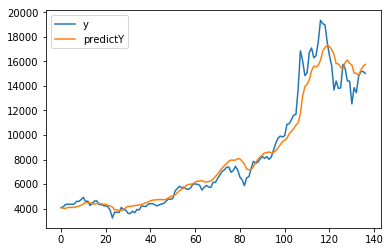

Lookback 5, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


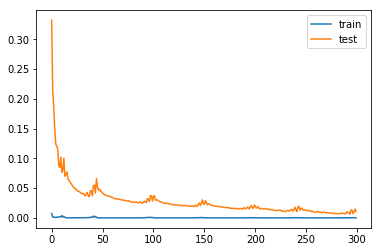

Test RMSE: 0.105


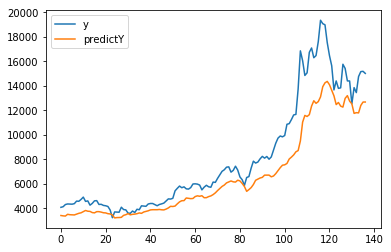

Lookback 5, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


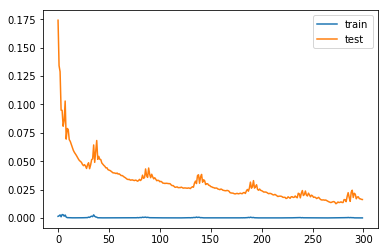

Test RMSE: 0.128


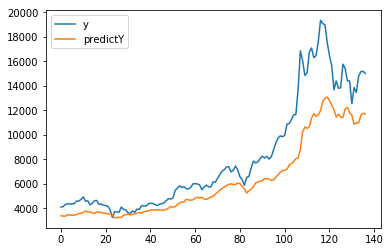

Lookback 6, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


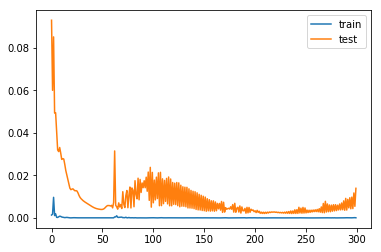

Test RMSE: 0.118


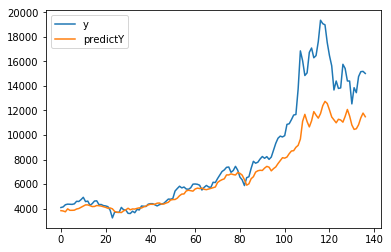

Lookback 6, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


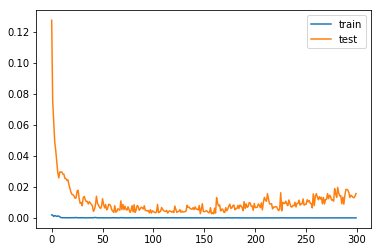

Test RMSE: 0.126


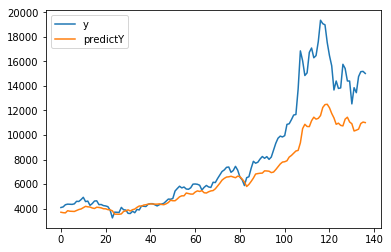

Lookback 6, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


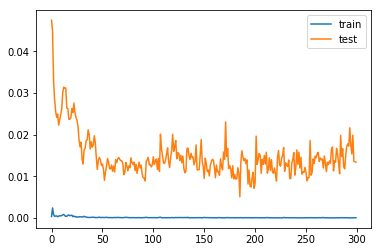

Test RMSE: 0.116


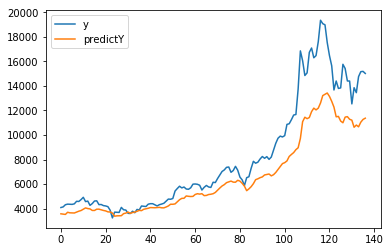

Lookback 6, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


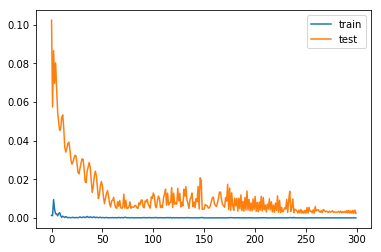

Test RMSE: 0.049


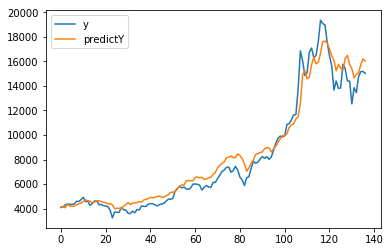

Lookback 6, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


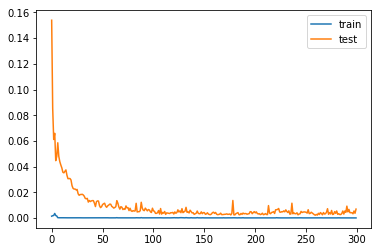

Test RMSE: 0.083


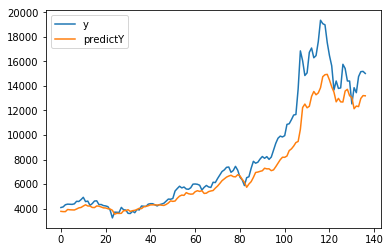

Lookback 6, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


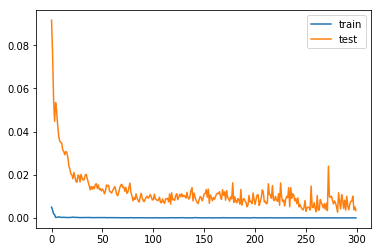

Test RMSE: 0.059


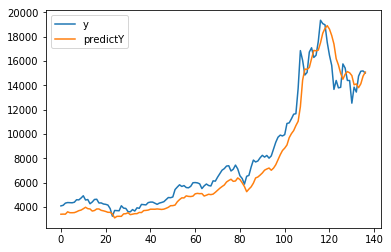

Lookback 6, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


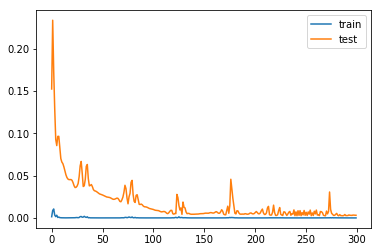

Test RMSE: 0.056


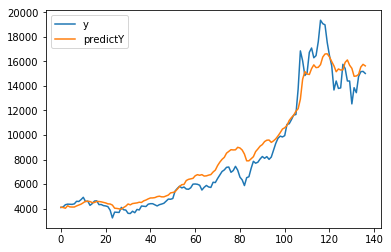

Lookback 6, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


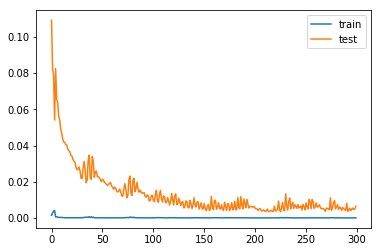

Test RMSE: 0.080


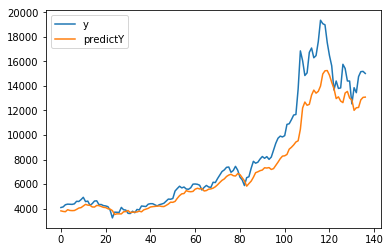

Lookback 6, batchsize 100, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


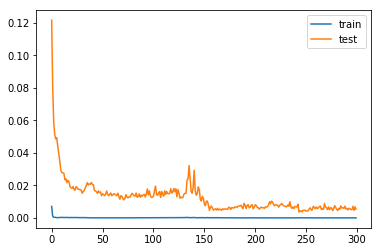

Test RMSE: 0.073


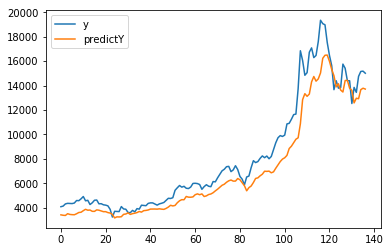

Lookback 6, batchsize 120, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


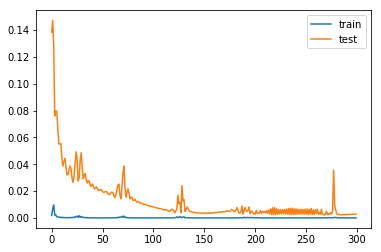

Test RMSE: 0.053


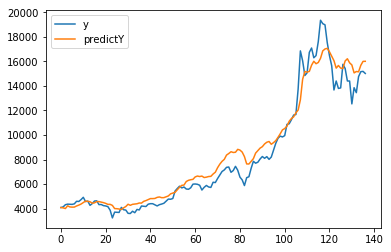

Lookback 6, batchsize 120, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


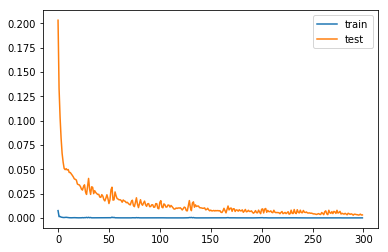

Test RMSE: 0.056


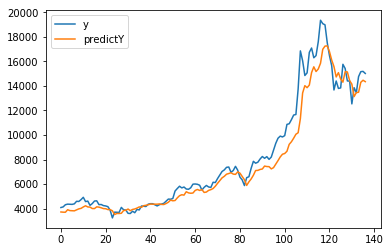

Lookback 6, batchsize 120, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


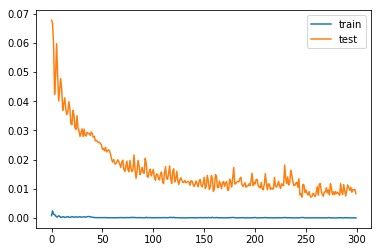

Test RMSE: 0.091


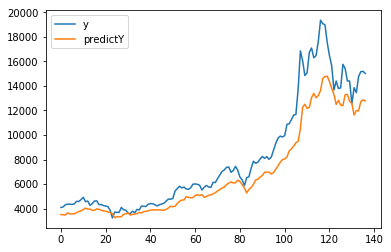

Lookback 6, batchsize 140, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


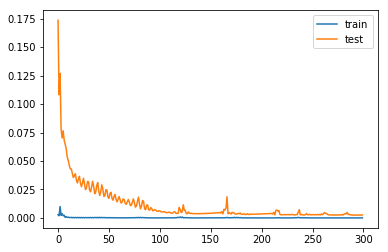

Test RMSE: 0.052


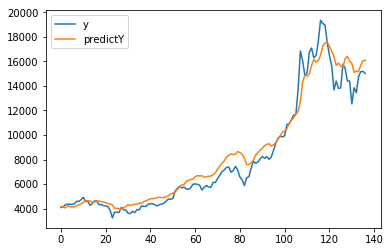

Lookback 6, batchsize 140, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


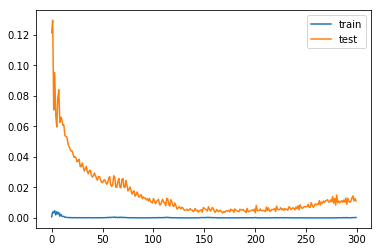

Test RMSE: 0.105


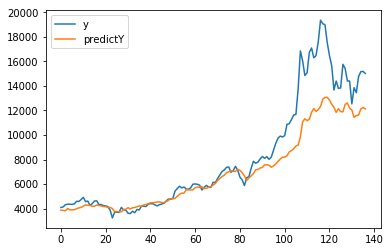

Lookback 6, batchsize 140, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


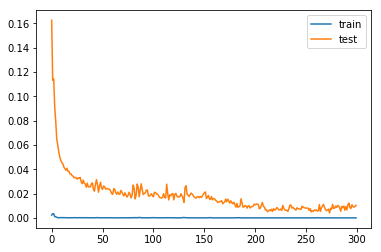

Test RMSE: 0.102


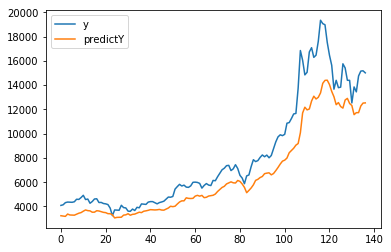

Lookback 6, batchsize 160, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


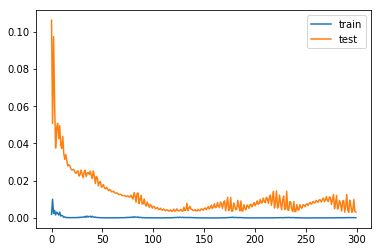

Test RMSE: 0.056


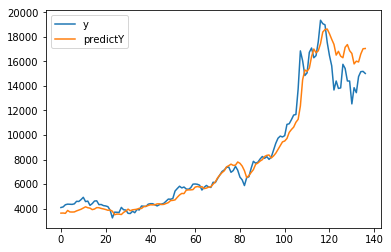

Lookback 6, batchsize 160, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


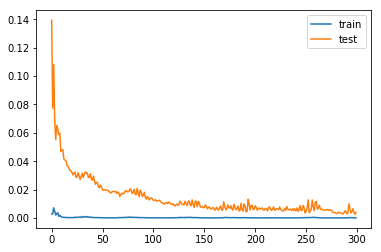

Test RMSE: 0.064


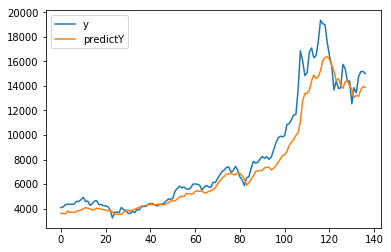

Lookback 6, batchsize 160, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


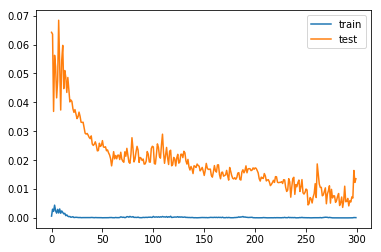

Test RMSE: 0.117


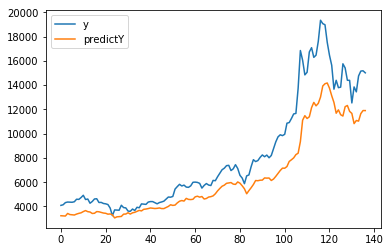

Lookback 6, batchsize 180, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


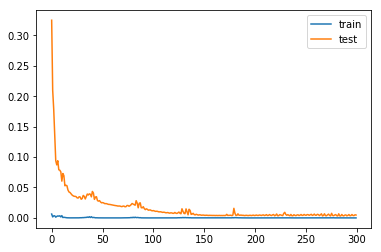

Test RMSE: 0.069


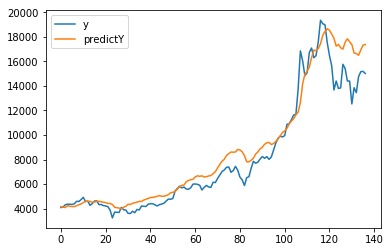

Lookback 6, batchsize 180, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


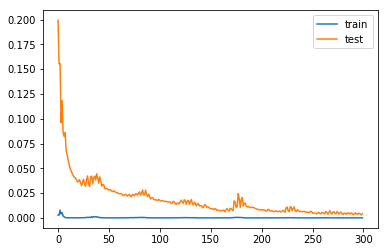

Test RMSE: 0.067


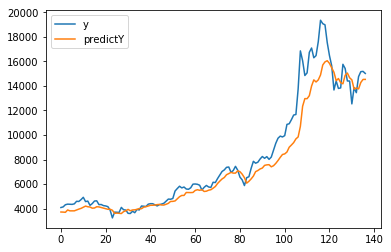

Lookback 6, batchsize 180, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


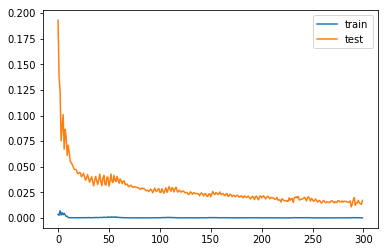

Test RMSE: 0.131


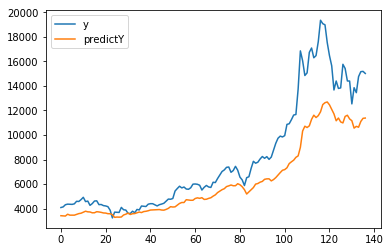

Lookback 6, batchsize 200, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


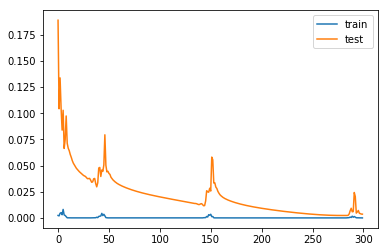

Test RMSE: 0.060


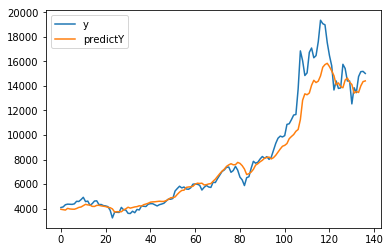

Lookback 6, batchsize 200, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


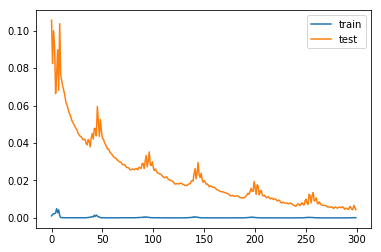

Test RMSE: 0.067


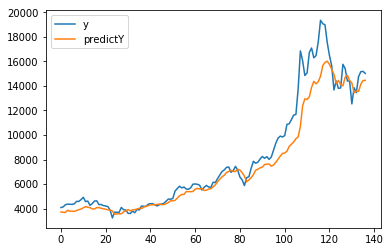

Lookback 6, batchsize 200, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


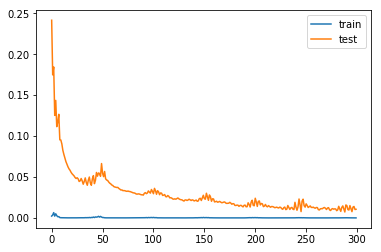

Test RMSE: 0.103


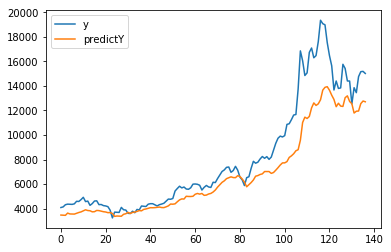

Lookback 6, batchsize 220, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


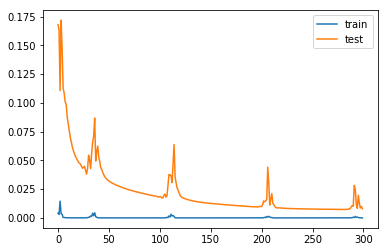

Test RMSE: 0.089


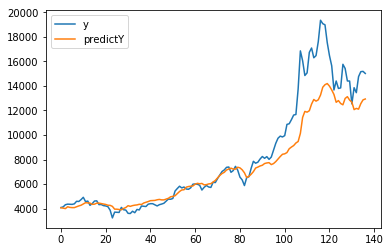

Lookback 6, batchsize 220, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


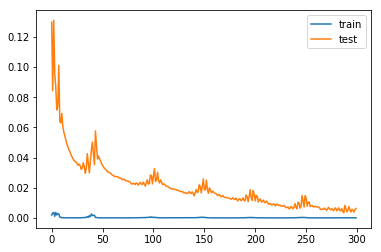

Test RMSE: 0.079


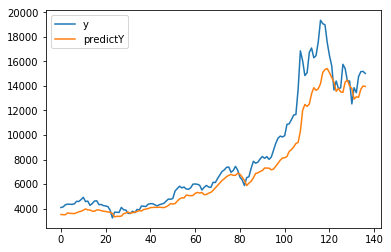

Lookback 6, batchsize 220, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


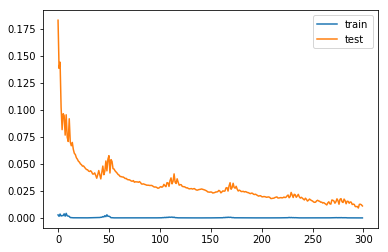

Test RMSE: 0.106


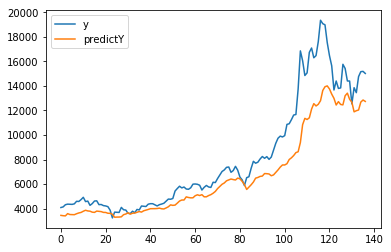

Lookback 6, batchsize 240, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


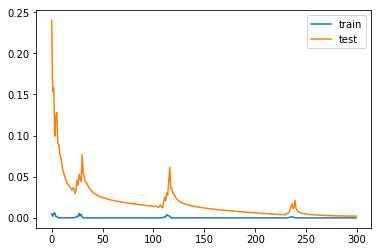

Test RMSE: 0.047


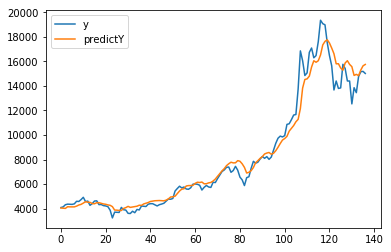

Lookback 6, batchsize 240, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


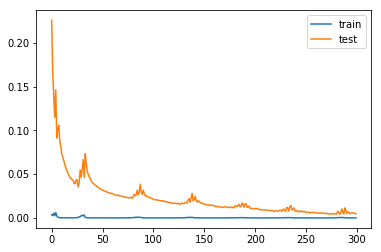

Test RMSE: 0.068


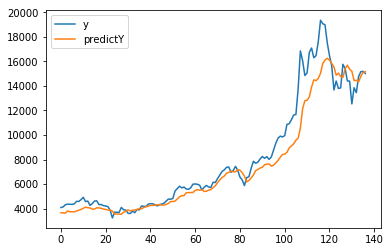

Lookback 6, batchsize 240, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


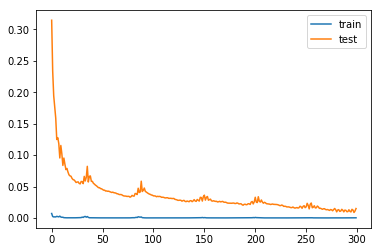

Test RMSE: 0.122


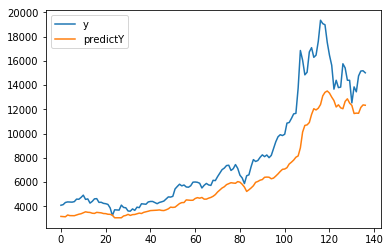

Lookback 7, batchsize 60, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


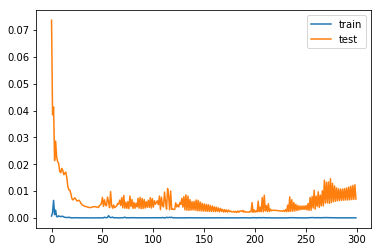

Test RMSE: 0.084


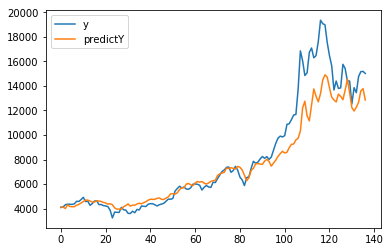

Lookback 7, batchsize 60, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


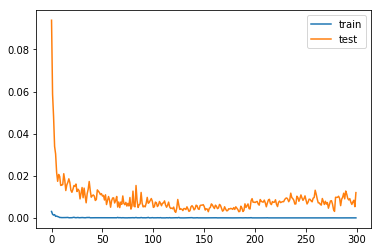

Test RMSE: 0.110


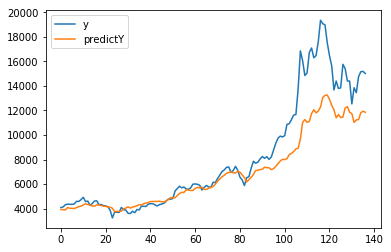

Lookback 7, batchsize 60, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


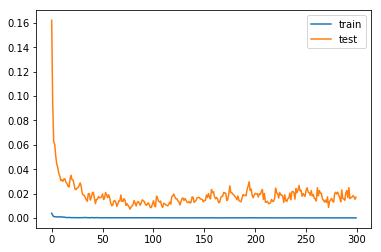

Test RMSE: 0.131


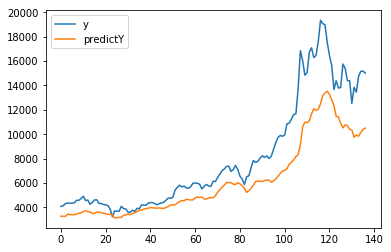

Lookback 7, batchsize 80, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


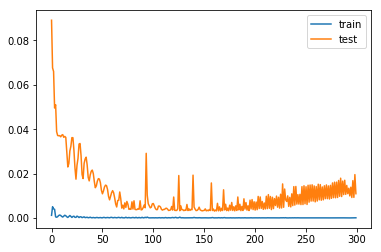

Test RMSE: 0.105


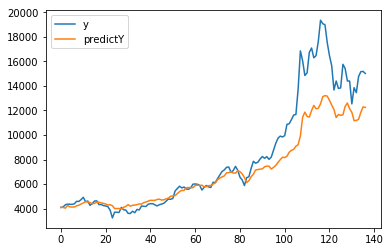

Lookback 7, batchsize 80, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


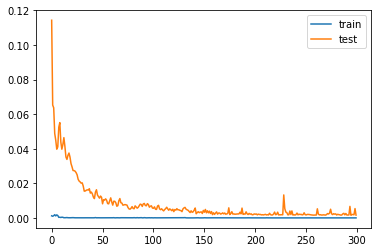

Test RMSE: 0.041


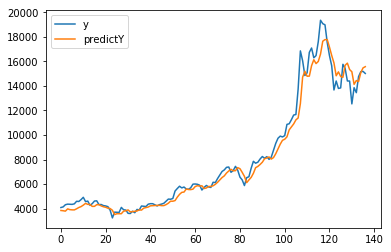

Lookback 7, batchsize 80, dropoff 0.2
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


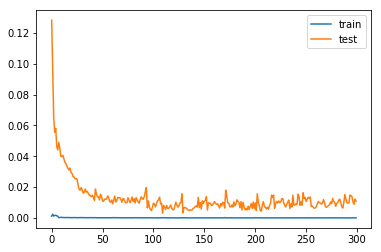

Test RMSE: 0.105


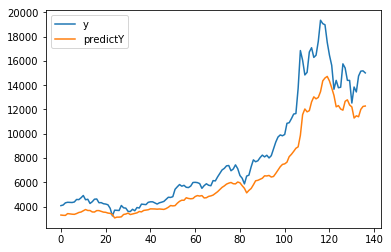

Lookback 7, batchsize 100, dropoff 0
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


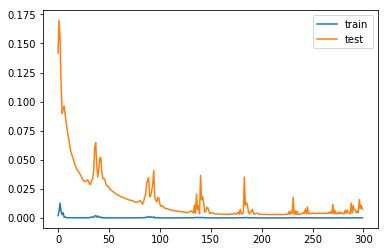

Test RMSE: 0.087


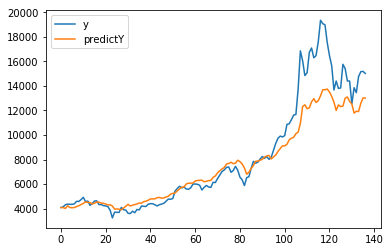

Lookback 7, batchsize 100, dropoff 0.1
Index(['BTC_close', 'BTC_difficulty', 'BTC_transition', 'BTC_cost',
       'BTC_total_coins', 'gold', 'oil', 'dollar'],
      dtype='object')


In [ ]:
#lookback 1-7
#batchsize 60-250
#dropout 0,0.1,0.2
for lookback in range(1, 8):
    for batchsize in [60, 80, 100, 120, 140, 160, 180, 200, 220, 240]:
        for dropoff in [0, 0.1, 0.2]:
            print('Lookback %s, batchsize %s, dropoff %s' % (lookback, batchsize, dropoff))
            predictedY, y, model, _ = runLSTM('result.csv', lookBack=lookback, trainPercent=0.95, 
                                              epochs=300, batchSize=batchsize, verbose=0, dropout=dropoff, loss='mse', optimizer='adam')



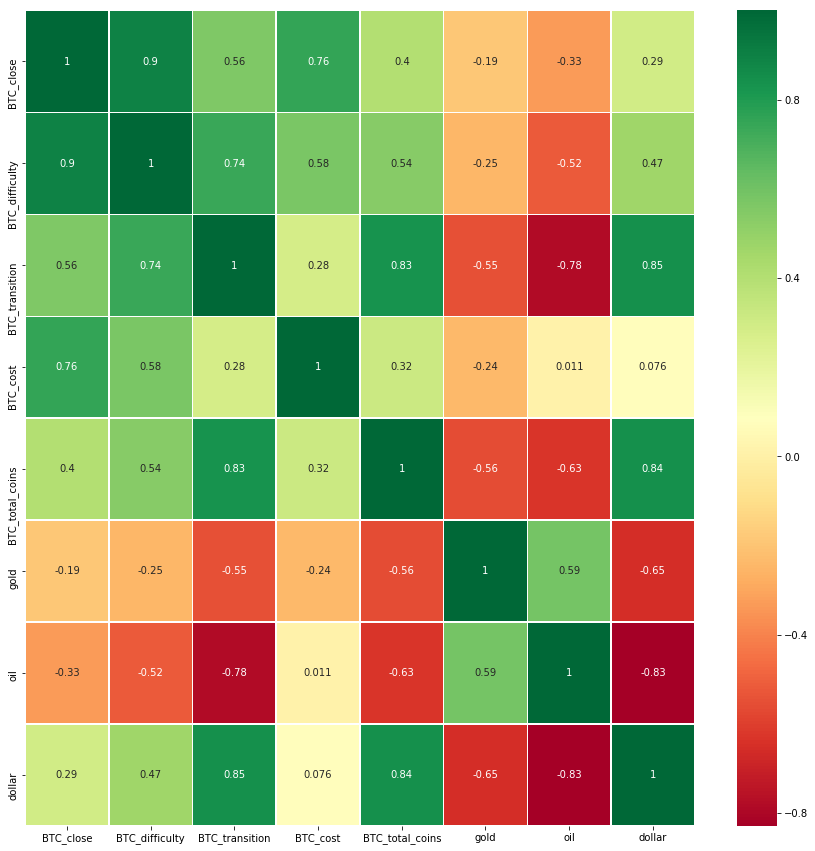

In [553]:
import seaborn as sns
fig, ax = pyplot.subplots(figsize=(15,15))
dataset = read_csv('result.csv',parse_dates = ['Date'], index_col='Date')
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=.5, ax=ax)
